In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
import re

In [5]:
# 解决matplotlib中文乱码

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

In [234]:
# 颜色
b = '#6699CC'

## 前提
有一天，你的运营同事找到你，说京东电商平台最近小家电类目的订单数量、产品浏览量、搜索数量等都有所下降， 现在部门计划对小家电类目进行一次季末促销活动，希望你能针对小家电的用户特征给出一些建议。

# 数据合并
2020年8月13日-8月19日
小家电类目订单数据

In [6]:
order_df = pd.read_csv("xjd_order_d.csv", sep='\t', encoding="utf-8", dtype=str)
user_df = pd.read_csv("xjd_user_info.csv", sep='\t',encoding="utf-8", dtype=str)
user_cart_df = pd.read_csv("xjd_user_cart.csv", sep='\t', encoding="utf-8", dtype=str)

In [7]:
# 查看数据缺失情况
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607712 entries, 0 to 607711
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_log_acct            607712 non-null  object
 1   parent_sale_ord_id       607712 non-null  object
 2   sale_ord_id              607712 non-null  object
 3   sale_ord_tm              607712 non-null  object
 4   sale_ord_dt              607712 non-null  object
 5   item_sku_id              607712 non-null  object
 6   item_name                607712 non-null  object
 7   brandname                607712 non-null  object
 8   sale_qtty                607712 non-null  object
 9   item_first_cate_name     607712 non-null  object
 10  item_second_cate_name    607712 non-null  object
 11  item_third_cate_name     607712 non-null  object
 12  before_prefr_unit_price  607712 non-null  object
 13  after_prefr_unit_price   607712 non-null  object
 14  user_actual_pay_amou

In [8]:
# change data type

order_df['sale_qtty'] = order_df['sale_qtty'].astype('int') # 商品数量
order_df['sale_ord_valid_flag'] = order_df['sale_ord_valid_flag'].astype('int') # 订单有效标志
order_df['cancel_flag'] = order_df['cancel_flag'].astype('int')  #订单取消标志
order_df['self_ord_flag'] = order_df['self_ord_flag'].astype('int') # 自营标志

order_df['before_prefr_unit_price'] = order_df['before_prefr_unit_price'].astype('float')
order_df['after_prefr_unit_price'] = order_df['after_prefr_unit_price'].astype('float')
order_df['user_actual_pay_amount'] = order_df['user_actual_pay_amount'].astype('float')
order_df['total_offer_amount'] = order_df['total_offer_amount'].astype('float')

order_df.loc[:,'check_account_tm '] = pd.to_datetime(order_df.loc[:,'check_account_tm'])
order_df.loc[:,'sale_ord_tm'] = pd.to_datetime(order_df.loc[:,'sale_ord_tm'])
order_df.loc[:,'sale_ord_dt'] = pd.to_datetime(order_df.loc[:,'sale_ord_dt'])

In [9]:
# missing values
order_df.isnull().sum().sort_values(ascending = False)

user_site_city_id          177620
user_site_province_id      177488
check_account_tm           100207
check_account_tm           100207
item_third_cate_name            0
parent_sale_ord_id              0
sale_ord_id                     0
sale_ord_tm                     0
sale_ord_dt                     0
item_sku_id                     0
item_name                       0
brandname                       0
sale_qtty                       0
item_first_cate_name            0
item_second_cate_name           0
after_prefr_unit_price          0
before_prefr_unit_price         0
wait_check_account_flag         0
user_actual_pay_amount          0
sale_ord_valid_flag             0
cancel_flag                     0
total_offer_amount              0
self_ord_flag                   0
user_lv_cd                      0
rev_addr_province_id            0
rev_addr_city_id                0
user_log_acct                   0
dtype: int64

In [10]:
order_df.head(3)

,user_log_acct,parent_sale_ord_id,sale_ord_id,sale_ord_tm,sale_ord_dt,item_sku_id,item_name,brandname,sale_qtty,item_first_cate_name,...,check_account_tm,total_offer_amount,self_ord_flag,user_site_city_id,user_site_province_id,user_lv_cd,rev_addr_province_id,rev_addr_city_id,wait_check_account_flag,check_account_tm
0,------1289,130704863113,124906164828,2020-08-18 00:02:10,2020-08-18,100009149228,飞利浦 (PHILIPS)蒸汽电熨斗家用 熨烫机 GC4902/28,飞利浦（PHILIPS）,2,家用电器,...,2020-08-18 00:02:25.0,639.4,1,0,0,50,1,2809,0,2020-08-18 00:02:25
1,------1289,130704863113,124903359952,2020-08-18 00:02:10,2020-08-18,4559760,德尔玛（Deerma） 加湿器 5L大容量 家用卧室静音 迷你香薰空气加湿 DEM-F60...,德尔玛（Deerma）,1,家用电器,...,2020-08-18 00:02:25.0,36.8,1,0,0,50,1,2809,0,2020-08-18 00:02:25
2,------1289,130704863113,130704863113,2020-08-18 00:02:10,2020-08-18,100009149228,飞利浦 (PHILIPS)蒸汽电熨斗家用 熨烫机 GC4902/28,飞利浦（PHILIPS）,2,家用电器,...,2020-08-18 00:02:23.0,0.0,1,0,0,50,1,2809,0,2020-08-18 00:02:23


In [11]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215090 entries, 0 to 215089
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_log_acct            215090 non-null  object
 1   ulp_base_sex             215090 non-null  object
 2   ulp_base_age             215090 non-null  object
 3   ulp_base_income          215090 non-null  object
 4   ulp_base_education       215090 non-null  object
 5   ulp_base_regprovince     215090 non-null  object
 6   ulp_base_regcity         215090 non-null  object
 7   ulp_user_reg_source_det  0 non-null       object
 8   ulp_user_reg_days        215090 non-null  object
 9   ulp_base_regtime         215090 non-null  object
 10  ulp_base_ulevel          215090 non-null  object
 11  ulp_jd_jx_value          215090 non-null  object
 12  ulp_is_plus_member       215090 non-null  object
 13  ulp_is_student_customer  215090 non-null  object
 14  ulp_base_profession 

In [12]:
user_df.head()

,user_log_acct,ulp_base_sex,ulp_base_age,ulp_base_income,ulp_base_education,ulp_base_regprovince,ulp_base_regcity,ulp_user_reg_source_det,ulp_user_reg_days,ulp_base_regtime,...,cvl_glob_values,cvl_glob_loyalty,cvl_glob_platform,cfv_sens_promotion,cfv_sens_comment,reg_user_type_cd,member_reg_gender,reg_birthday,last_login_tm,factory_user_flag
0,1030914909,0,3,-1,3,-1,闵行区,NaN,3164,2011-12,...,0.6480779,中度-忠诚型,-1.0,L1-3,L1-4,NaN,0,NaN,2019-06-08 22:18:32.0,1
1,103385299,1,3,-1,4,-1,温州市,NaN,3969,2009-10,...,4.023711,高度-忠诚型,-1.0,L1-4,L1-4,44,0,1991-9-9,2020-08-13 18:32:57.0,0
2,10638747-707577,1,3,-1,3,-1,朝阳区,NaN,2637,2013-05,...,1.6201134,高度-忠诚型,43.38952623913664,L1-2,L1-5,NaN,0,1992-4-3,2020-06-20 17:11:33.0,1
3,1087096-78471807,1,4,-1,4,-1,-1,NaN,3740,2010-05,...,15.702956,高度-忠诚型,-1.0,L1-3,L1-4,NaN,0,2014-1-1,2020-08-13 12:16:12.0,1
4,1090625252_m,1,6,-1,2,-1,-1,NaN,2379,2014-02,...,1.3287612,近期-普通型,-1.0,L1-4,L1-3,NaN,2,NaN,2019-09-28 10:29:32.0,1


In [13]:
user_df["user_log_acct"].nunique()

215090

In [14]:
# 合并order和user表，获取有订单的用户

order_user_df = pd.merge(order_df, user_df, on = 'user_log_acct')
order_user_df.head()

,user_log_acct,parent_sale_ord_id,sale_ord_id,sale_ord_tm,sale_ord_dt,item_sku_id,item_name,brandname,sale_qtty,item_first_cate_name,...,cvl_glob_values,cvl_glob_loyalty,cvl_glob_platform,cfv_sens_promotion,cfv_sens_comment,reg_user_type_cd,member_reg_gender,reg_birthday,last_login_tm,factory_user_flag
0,------1289,130704863113,124906164828,2020-08-18 00:02:10,2020-08-18,100009149228,飞利浦 (PHILIPS)蒸汽电熨斗家用 熨烫机 GC4902/28,飞利浦（PHILIPS）,2,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0
1,------1289,130704863113,124903359952,2020-08-18 00:02:10,2020-08-18,4559760,德尔玛（Deerma） 加湿器 5L大容量 家用卧室静音 迷你香薰空气加湿 DEM-F60...,德尔玛（Deerma）,1,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0
2,------1289,130704863113,130704863113,2020-08-18 00:02:10,2020-08-18,100009149228,飞利浦 (PHILIPS)蒸汽电熨斗家用 熨烫机 GC4902/28,飞利浦（PHILIPS）,2,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0
3,------1289,130699964163,130699964163,2020-08-18 00:00:16,2020-08-18,100011967276,爱丽思(IRIS OHYAMA)日本 吸尘器 无线家用充电手持轻便智能吸尘机IC-SDC2C（粉）,IRIS OHYAMA,3,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0
4,------1289,130704863113,124903359952,2020-08-18 00:02:10,2020-08-18,100006533674,德尔玛（Deerma）加湿器净水盒 水箱专用 通用 银离子净水盒,德尔玛（Deerma）,1,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0


In [15]:
order_user_df.shape

(607712, 65)

In [16]:
# 对下过订单的用户，以用户ID进行去重，保留重复数据的第一个
user_info_df = order_user_df.drop_duplicates(subset = ["user_log_acct"],keep = "first")

In [17]:
user_info_df

,user_log_acct,parent_sale_ord_id,sale_ord_id,sale_ord_tm,sale_ord_dt,item_sku_id,item_name,brandname,sale_qtty,item_first_cate_name,...,cvl_glob_values,cvl_glob_loyalty,cvl_glob_platform,cfv_sens_promotion,cfv_sens_comment,reg_user_type_cd,member_reg_gender,reg_birthday,last_login_tm,factory_user_flag
0,------1289,130704863113,124906164828,2020-08-18 00:02:10,2020-08-18,100009149228,飞利浦 (PHILIPS)蒸汽电熨斗家用 熨烫机 GC4902/28,飞利浦（PHILIPS）,2,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0
7,---刺猬,130744622338,130744622338,2020-08-18 18:11:35,2020-08-18,100001679413,安吉尔（Angel）茶吧机立式家用办公室饮水机多功能自动上水柜式茶吧机下置水桶式CB2705...,安吉尔（Angel）,1,家用电器,...,1.8591628,高度-忠诚型,79.13798834497094,L1-2,L1-5,NaN,2,NaN,2019-12-11 18:29:44.0,1
10,--寂,124775599894,124775599894,2020-08-15 12:49:06,2020-08-15,2392546,赛亿（Shinee）小风扇 台扇/台夹扇 壁扇 迷你静音学生宿舍床头办公室桌面换气电风扇FJ...,赛亿（Shinee）,1,家用电器,...,3.1875074,高度-忠诚型,-1.0,L1-4,L1-5,NaN,2,NaN,2020-02-25 15:01:41.0,1
13,-love明-,130503457517,130501451054,2020-08-15 19:47:49,2020-08-15,3085665,松下（Panasonic）吸尘器MC-WF350手持式真空吸尘器家用超大吸力手提式系列吸尘器...,松下（Panasonic）,1,家用电器,...,9.721487,高度-忠诚型,69.12535255785926,L1-4,L1-5,NaN,0,1988-1-17,2020-08-08 20:34:47.0,1
16,-zhongzhong,124778603709,130550058117,2020-08-15 12:53:08,2020-08-15,100012373764,格力 （GREE）新品家用智能遥控定时电风扇/塔式落地扇/直流变频电扇/立式塔扇/无叶风扇F...,格力（GREE）,1,家用电器,...,18.505648,高度-忠诚型,63.646321011381815,L1-3,L1-5,NaN,0,1986-10-22,2020-08-12 14:24:47.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607704,龙龙豆豆1988,124905744754,124905744754,2020-08-18 01:43:56,2020-08-18,5149337,碧然德（BRITA）家用净水壶 滤水壶滤芯 MAXTRA+LE 去水垢专家滤芯 6枚装,碧然德,3,家用电器,...,6.1628323,高度-忠诚型,85.79622152813988,L1-4,L1-5,NaN,1,1988-12-13,2020-08-06 10:15:03.0,1
607706,龚凤波,124863599292,124863599292,2020-08-17 08:13:19,2020-08-17,100005221904,康佳（KONKA）大型家用商用空调扇 制冷风扇 冷风机 冷风扇 车间食堂餐厅网吧大排档移动工...,康佳（KONKA）,1,家用电器,...,3.9117951,高度-忠诚型,-1.0,L1-2,L1-3,1,2,NaN,2017-04-28 14:18:32.0,0
607707,龚天睿,124772876191,124772404564,2020-08-15 11:03:24,2020-08-15,5149351,碧然德（BRITA）家用净水壶 滤水壶滤芯 MAXTRA+LE 去水垢专家滤芯 3枚装,碧然德,1,家用电器,...,2.4423106,高度-忠诚型,74.56211872975473,L1-4,L1-5,NaN,0,2011-1-1,2019-12-04 22:35:59.0,1
607710,龚思嘉,124875168188,124875168188,2020-08-17 12:35:34,2020-08-17,4460778,沁园（TRULIVA）家用净水器 即滤型超滤机 长寿命滤芯 无废水 矿物质净水机 QJ-UF...,沁园（TRULIVA）,1,家用电器,...,7.002889,高度-忠诚型,15.897319691476284,L1-4,L1-5,NaN,0,0001-1-1,2019-11-02 09:57:09.0,1


# 用户基本属性

## 性别分布

在全部订单中，只要下过单的用户（无论订单是否有效），都计算在内

In [18]:
user_sex_df = user_info_df.groupby(["ulp_base_sex"],as_index=False)["user_log_acct"].agg({'ulp_base_sex_count':'count'})
user_sex_df

,ulp_base_sex,ulp_base_sex_count
0,-1,2164
1,0,95974
2,1,116952


In [19]:
female_user = user_sex_df['ulp_base_sex_count'][1] # 女性用户
male_user = user_sex_df['ulp_base_sex_count'][2] # 男性用户

Text(0.5, 1.0, '小家电消费用户的性别分布')

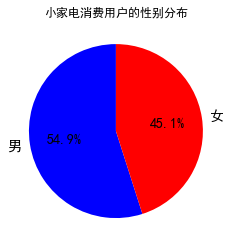

In [20]:
labels = ["男","女"]
colors = ["b","r"]
plt.pie([male_user,female_user], autopct = "%1.1f%%", labels = labels, 
       startangle = 90, colors = colors, textprops = {"fontsize":14})
plt.title("小家电消费用户的性别分布")

## 用户年龄分布

In [21]:
# age每一个数字代表一个年龄区间
user_age_df = user_info_df.groupby(["ulp_base_age"],as_index=False)["user_log_acct"].agg({'user_age_count':'count'})
user_age_df['ulp_base_age'] = user_age_df['ulp_base_age'].astype('int')
user_age_df = user_age_df[user_age_df.ulp_base_age>-1]
user_age_df

,ulp_base_age,user_age_count
1,1,21
2,2,27947
3,3,105501
4,4,56682
5,5,12177
6,6,11074


In [22]:
x = ['18岁以下', '18~25岁',  '25~35岁', '35~45岁', '45~55岁', '55岁以上']
y = user_age_df['user_age_count']

<BarContainer object of 6 artists>

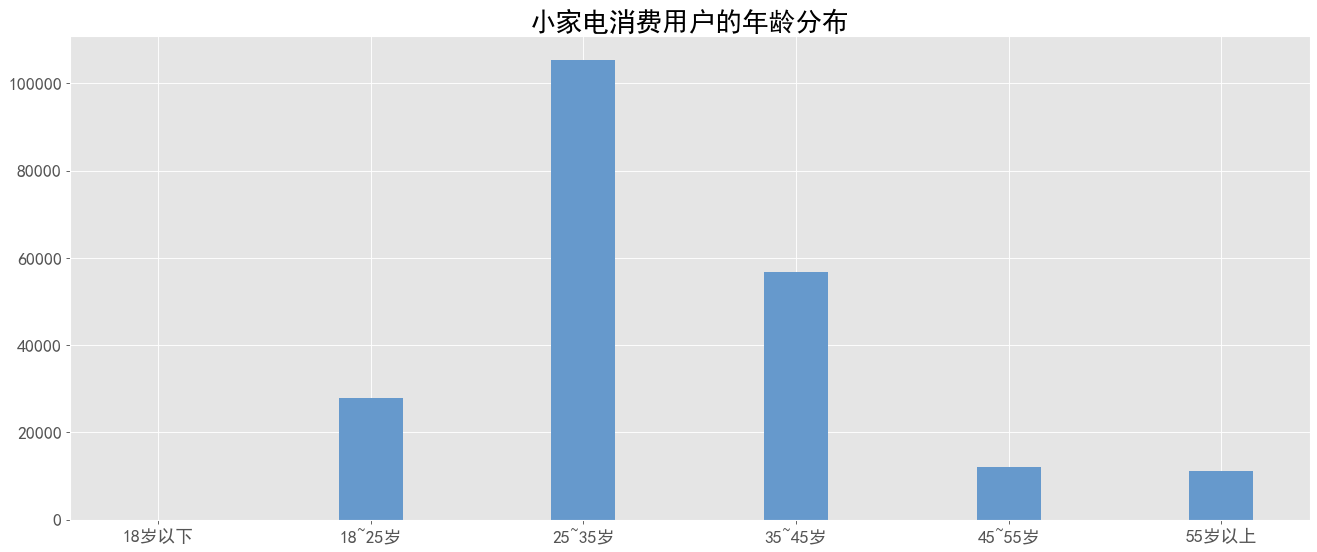

In [23]:
plt.figure(figsize=(20,8),dpi=80)
plt.style.use('ggplot')

plt.title("小家电消费用户的年龄分布", size=24) # 图标题

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.bar(x, y, width=0.3, color='#6699CC')

### 性别x年龄分布

In [24]:
age_gender_df = user_info_df.groupby(["ulp_base_age","ulp_base_sex"],as_index=False)["user_log_acct"].agg({'user_gender_age_count':'count'})
age_gender_df["ulp_base_age"] = age_gender_df["ulp_base_age"].astype(int)
age_gender_df

,ulp_base_age,ulp_base_sex,user_gender_age_count
0,-1,-1,1225
1,-1,0,219
2,-1,1,244
3,1,0,8
4,1,1,13
5,2,-1,201
6,2,0,11590
7,2,1,16156
8,3,-1,299
9,3,0,49258


In [25]:
# 去掉为年龄组为-1的部分
i = age_gender_df[age_gender_df.ulp_base_age == -1].index
age_gender_df.drop(i, axis = 0, inplace = True)

In [26]:
# 获取统计数据（按性别）
female = age_gender_df[age_gender_df.ulp_base_sex == "0"][["ulp_base_age","user_gender_age_count"]]
male =  age_gender_df[age_gender_df.ulp_base_sex == "1"][["ulp_base_age","user_gender_age_count"]]

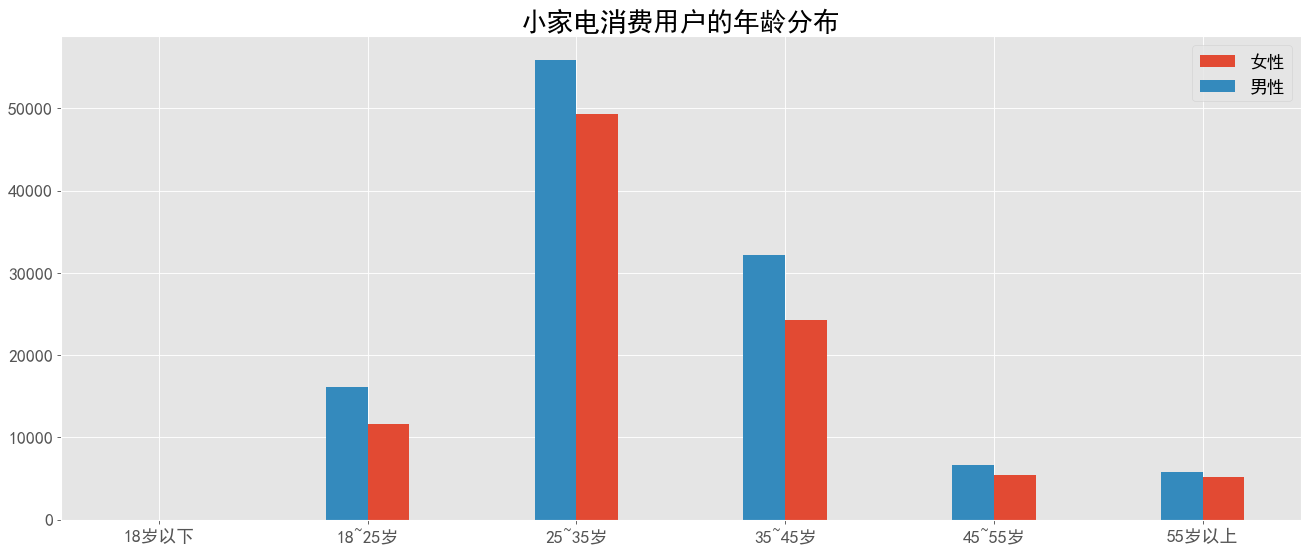

In [27]:
N = 6 # number of labels
ind = np.arange(N)+1.1 # change the location of labels in axis

fig = plt.figure(figsize=(20, 8), dpi=80)
ax = fig.add_subplot(111)

ax.bar(female["ulp_base_age"]+0.2,female["user_gender_age_count"], width=0.2,align='center')
ax.bar(male["ulp_base_age"], male["user_gender_age_count"], width=0.2,align='center')

ax.set_xticklabels(x, size = 16)
ax.set_xticks(ind) # set label locations
ax.set_yticklabels([0,10000,20000,30000,40000,50000],size = 16)
ax.set_title("小家电消费用户的年龄分布", size=24)
ax.legend(('女性', '男性'),prop={'size': 16})

## 用户地域分布

In [28]:
user_region_df = user_info_df.groupby('ulp_addr_province', as_index=False)['user_log_acct'].agg({'region_count':'count'})
user_region_df.columns = ['province_name','region_count']
user_region_df = user_region_df.sort_values(by='region_count', ascending=False)
user_region_df

,province_name,region_count
12,广东,35247
15,江苏,19370
4,北京,19214
1,上海,14627
10,山东,14391
6,四川,11003
21,湖北,9504
19,浙江,9455
17,河北,8147
27,辽宁,7023


In [29]:
i = user_region_df[user_region_df.province_name == "-1"].index
user_region_df.drop(i,axis = 0, inplace = True)

In [30]:
user_region_df["province_name"].nunique()

31

In [31]:
# 用to_csv(...encoding = "utf-8")导致了乱码
# 在tableau进行了可视化
user_region_df.to_excel("user_region_df.xlsx", encoding = "utf-8")

In [32]:
x = user_region_df['province_name'][::-1]  # 切片方法，让列表反向。两个冒号分隔为{起始位置：终止位置：步长}
y = user_region_df['region_count'][::-1]  # 其中步长为正，从左往右取，步长为负，从右往左取

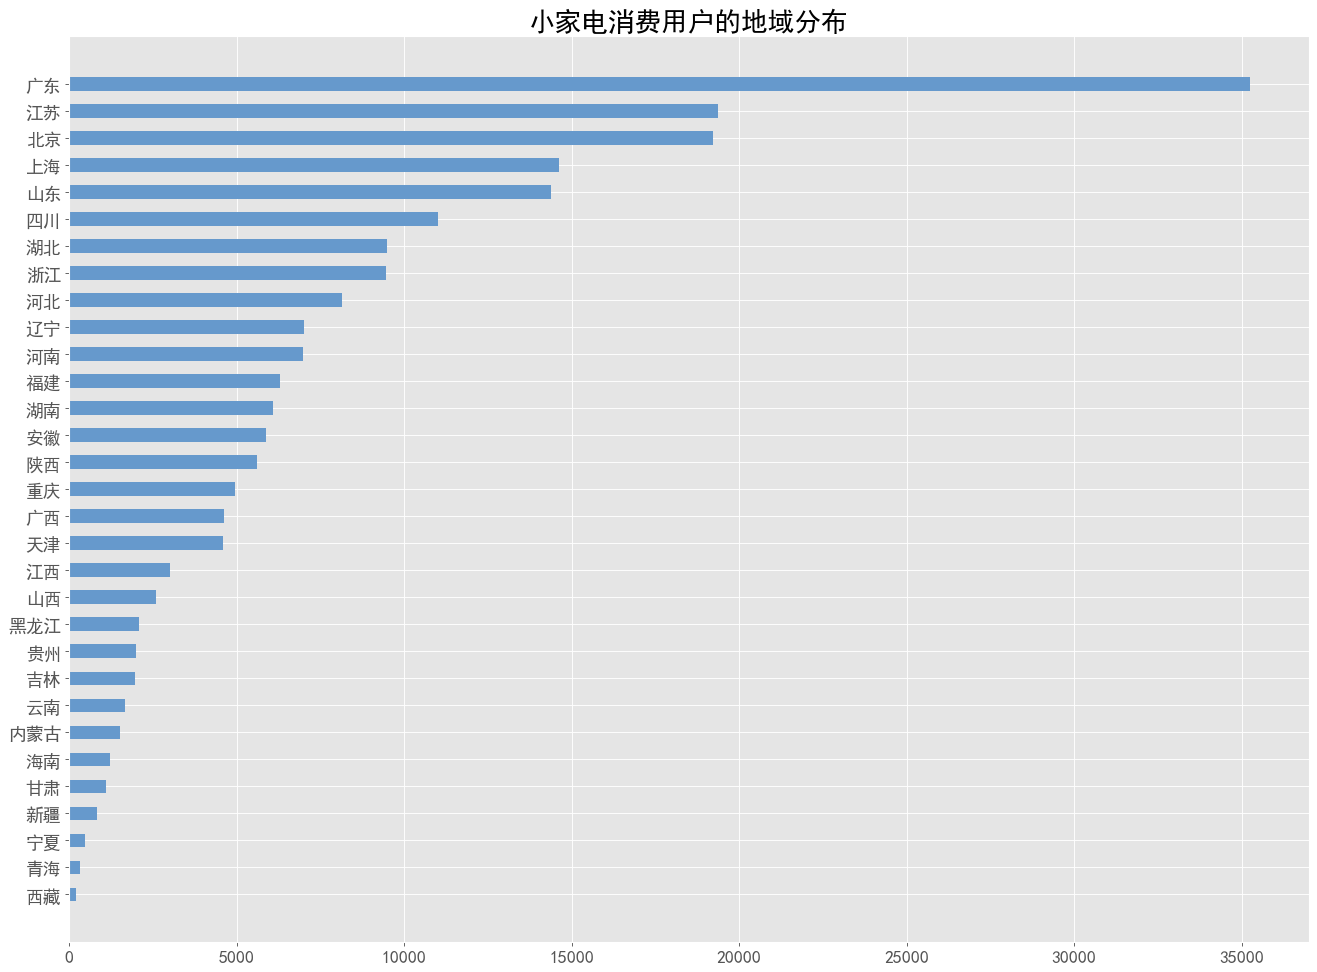

In [33]:
plt.figure(figsize=(20,15), dpi=80)

plt.title("小家电消费用户的地域分布", size=24) # 图标题

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.barh(x, y, height=0.5, color='#6699CC')

plt.show()

## 小家电消费用户的城市分布

In [34]:
user_city_df = user_info_df.groupby('ulp_addr_city', as_index=False)['user_log_acct'].agg({'city_count':'count'}).sort_values(by='city_count', ascending=False)
user_city_df

,ulp_addr_city,city_count
50,北京市,19214
6,上海市,14627
128,广州市,9674
217,深圳市,8839
146,成都市,6788
...,...,...
305,那曲地区,5
353,黄南藏族自治州,4
247,白沙黎族自治县,4
257,神农架林区,4


In [35]:
# 头部城市
user_city_df = user_city_df[:10]
user_city_df

,ulp_addr_city,city_count
50,北京市,19214
6,上海市,14627
128,广州市,9674
217,深圳市,8839
146,成都市,6788
269,苏州市,5754
188,武汉市,5538
313,重庆市,4943
94,天津市,4585
343,青岛市,3786


In [36]:
x = user_city_df['ulp_addr_city'][::-1]
y = user_city_df['city_count'][::-1]

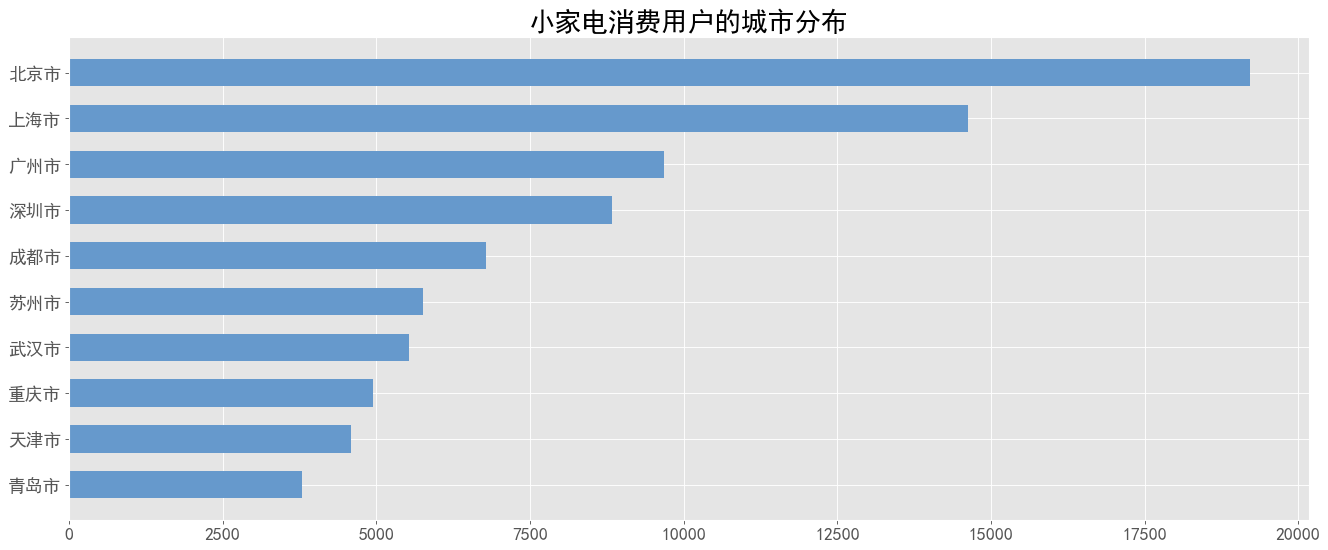

In [37]:
plt.figure(figsize=(20,8),dpi=80)

plt.title("小家电消费用户的城市分布", size=24) # 图标题

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.barh(x, y, align='center', height=0.6, color='#6699CC') # height是水平条形图宽度

plt.show()

## 用户的婚育状况

In [38]:
user_marriage_df = user_info_df.groupby('ulp_base_marriage', as_index=False)['user_log_acct']\
    .agg({'marriage': 'count'})\
    .sort_values(by='marriage', ascending=False)
user_marriage_df

,ulp_base_marriage,marriage
2,1,143755
1,0,65802
0,-1,5533


In [39]:
married_user = user_marriage_df['marriage'].iloc[0] # 取第0行
unmarried_user = user_marriage_df['marriage'].iloc[1] # 取第1行

Text(0.5, 1.0, '小家电消费用户的婚姻情况')

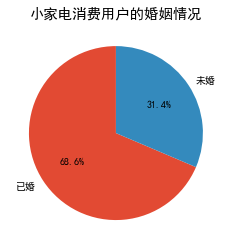

In [40]:
labels = ['已婚', '未婚']
Y = [married_user, unmarried_user]
fig = plt.figure()
plt.pie(Y, labels=labels, autopct='%1.1f%%', startangle=90) # startangle是图旋转角度
plt.title("小家电消费用户的婚姻情况")

## 小家电消费用户的有孩可能性

In [41]:
user_child_df = user_info_df.groupby('ulp_base_child', as_index=False)['user_log_acct']\
                .agg({'child':'count'})\
                .sort_values(by='child', ascending=False)
user_child_df

,ulp_base_child,child
0,-1,63774
3,较高,58209
4,高,38502
2,较低,29468
1,低,25137


In [42]:
user_child_df = user_child_df[user_child_df['ulp_base_child'] != '-1']
user_child_df

,ulp_base_child,child
3,较高,58209
4,高,38502
2,较低,29468
1,低,25137


In [43]:
very_high = user_child_df['child'].iloc[1] # 高，取第1行
high = user_child_df['child'].iloc[0] # 较高，取第0行
low = user_child_df['child'].iloc[2] # 较低，取第2行
very_low = user_child_df['child'].iloc[3] # 低，取第3行

Text(0.5, 1.0, '小家电消费用户的有孩可能性')

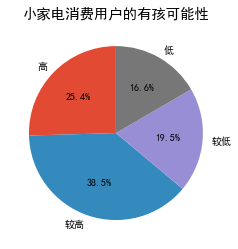

In [44]:
labels = ['高', '较高', '较低', '低']
Y = [very_high, high, low, very_low]
fig = plt.figure()
plt.pie(Y, labels=labels, autopct='%1.1f%%', startangle=90) # startangle是图旋转角度
plt.title("小家电消费用户的有孩可能性")

### 孩子性别

该部分信息无法获取

In [45]:
user_info_df["ulp_seni_childsex"].nunique()

1

### 孩子年龄

In [46]:
child_month_df = user_info_df.groupby("ulp_seni_childage", as_index = False)["user_log_acct"].agg({"childage_count":"count"})
child_month_df = child_month_df[child_month_df["ulp_seni_childage"]>="0"]
child_month_df = child_month_df.sort_values(by = "ulp_seni_childage", ascending = False)
child_month_df

,ulp_seni_childage,childage_count
104,2021-06,2
103,2021-05,2
102,2021-04,15
101,2021-03,312
100,2021-02,555
...,...,...
5,2013-03,70
4,2013-02,80
3,2013-01,86
2,2012-12,72


In [47]:
# 将2020年10月开始的日期视作无效日期
child_month_df = child_month_df[child_month_df.ulp_seni_childage<"2020-10"]
child_month_df.loc["ulp_seni_childage"] = child_month_df["ulp_seni_childage"].astype(str)
child_month_df.shape

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(96, 2)

In [48]:
# 通过正则表达取出时间（年，月）

child_month_df["year"] = child_month_df["ulp_seni_childage"].str.extract(r'([0-9+]{4})-[0-9]{2}',expand = True)
child_month_df["month"] = child_month_df["ulp_seni_childage"].str.extract(r'[0-9+]{4}-([0-9]{2})',expand = False)
child_month_df.head()

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ulp_seni_childage,childage_count,year,month
95,2020-09,1145.0,2020,09
94,2020-08,1552.0,2020,08
93,2020-07,2176.0,2020,07
92,2020-06,3039.0,2020,06
91,2020-05,3052.0,2020,05


In [49]:
child_month_df.isnull().sum()

ulp_seni_childage    1
childage_count       1
year                 1
month                1
dtype: int64

In [50]:
# 去掉NA
child_month_df = child_month_df[~child_month_df.year.isnull()]
child_month_df.isnull().sum()

ulp_seni_childage    0
childage_count       0
year                 0
month                0
dtype: int64

In [51]:
# 计算年龄
child_month_df["age"] = 2020-child_month_df["year"].astype(int)+child_month_df["month"].astype(int)*30/365
child_month_df["age"] = round(child_month_df["age"],2)
child_month_df

,ulp_seni_childage,childage_count,year,month,age
95,2020-09,1145.0,2020,09,0.74
94,2020-08,1552.0,2020,08,0.66
93,2020-07,2176.0,2020,07,0.58
92,2020-06,3039.0,2020,06,0.49
91,2020-05,3052.0,2020,05,0.41
...,...,...,...,...,...
5,2013-03,70.0,2013,03,7.25
4,2013-02,80.0,2013,02,7.16
3,2013-01,86.0,2013,01,7.08
2,2012-12,72.0,2012,12,8.99


In [52]:
# 分箱
bins = [0,3,6,9,15]
labels = ["3岁及以下","3-6（含）岁", "6-9（含）岁","9岁以上"]
child_month_df["age_range"] = pd.cut(child_month_df["age"],bins = bins,labels = labels)

# groupby
child_age_range_df = child_month_df.groupby("age_range",as_index = False)["childage_count"].sum()
child_age_range_df

,age_range,childage_count
0,3岁及以下,76551.0
1,3-6（含）岁,22999.0
2,6-9（含）岁,3540.0
3,9岁以上,0.0


Text(0.5, 1.0, '小家电消费用户的孩子年龄分布')

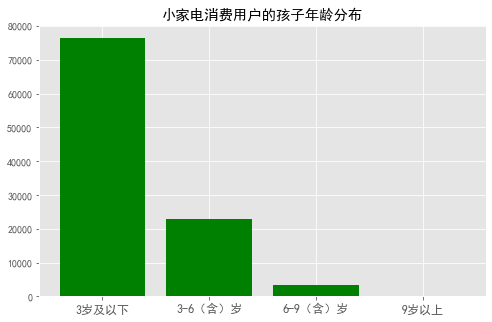

In [53]:
# visualization
fig = plt.figure(figsize = (8,5))
plt.bar(child_age_range_df["age_range"], child_age_range_df["childage_count"],color = "g")
plt.xticks(size = 12)
plt.title("小家电消费用户的孩子年龄分布")

In [54]:
child_month_df.year.isnull().sum()

0

In [55]:
child_month_df["year"] = child_month_df["year"].astype(int)

In [56]:
child_month_df.head()

,ulp_seni_childage,childage_count,year,month,age,age_range
95,2020-09,1145.0,2020,09,0.74,3岁及以下
94,2020-08,1552.0,2020,08,0.66,3岁及以下
93,2020-07,2176.0,2020,07,0.58,3岁及以下
92,2020-06,3039.0,2020,06,0.49,3岁及以下
91,2020-05,3052.0,2020,05,0.41,3岁及以下


In [57]:
# 将data转化为date格式
#child_month_df.loc["ulp_seni_childage"] = pd.to_datetime(child_month_df["ulp_seni_childage"])
#child_month_df.head()

In [58]:
# 本月
#this_month = datetime.strptime("2020-10-01","%Y-%m-%d")
#child_month_df["age"] = this_month - child_month_df["ulp_seni_childage"]
#child_month_df.head()

In [59]:
child_month_df.dtypes

ulp_seni_childage      object
childage_count        float64
year                    int32
month                  object
age                   float64
age_range            category
dtype: object

## 用户的教育水平

In [60]:
user_edu_df = user_info_df.groupby('ulp_base_education', as_index=False)['user_log_acct']\
                .agg({'edu':'count'})\
                .sort_values(by='ulp_base_education', ascending=True)
user_edu_df

,ulp_base_education,edu
0,-1,13872
1,1,3555
2,2,36788
3,3,131534
4,4,29341


In [61]:
user_edu_df = user_edu_df[user_edu_df['ulp_base_education'] != '-1']
user_edu_df

,ulp_base_education,edu
1,1,3555
2,2,36788
3,3,131534
4,4,29341


<BarContainer object of 4 artists>

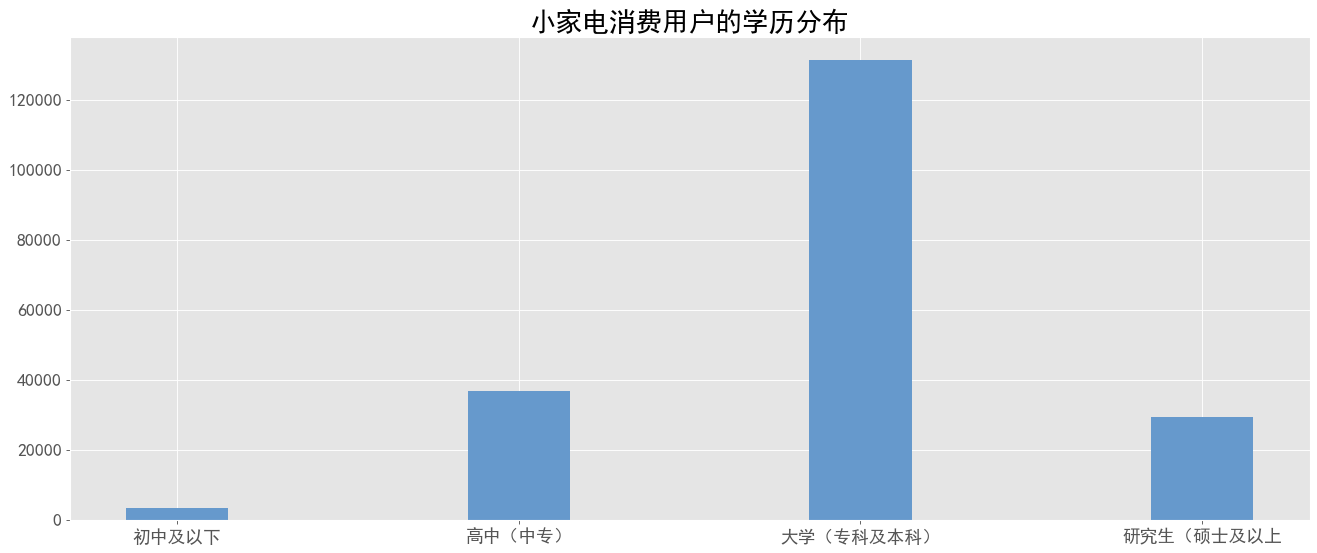

In [62]:
x = ['初中及以下', '高中（中专）', '大学（专科及本科）', '研究生（硕士及以上']
y = user_edu_df['edu']

plt.figure(figsize=(20,8),dpi=80)
plt.style.use('ggplot')
plt.title("小家电消费用户的学历分布", size=24)

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.bar(x, y, width=0.3, color='#6699CC')

## 小家电消费用户的职业分布

In [63]:
user_profession_df = user_info_df.groupby('ulp_base_profession', as_index=False)['user_log_acct']\
                    .agg({'profession':'count'})\
                    .sort_values(by='ulp_base_profession', ascending=True)
user_profession_df

,ulp_base_profession,profession
0,-1,61755
1,a,3492
2,b,4268
3,c,10195
4,d,37080
5,e,14675
6,f,33167
7,g,40932
8,h,9526


In [64]:
user_profession_df = user_profession_df[user_profession_df['ulp_base_profession'] != '-1']
user_profession_df

,ulp_base_profession,profession
1,a,3492
2,b,4268
3,c,10195
4,d,37080
5,e,14675
6,f,33167
7,g,40932
8,h,9526


<BarContainer object of 8 artists>

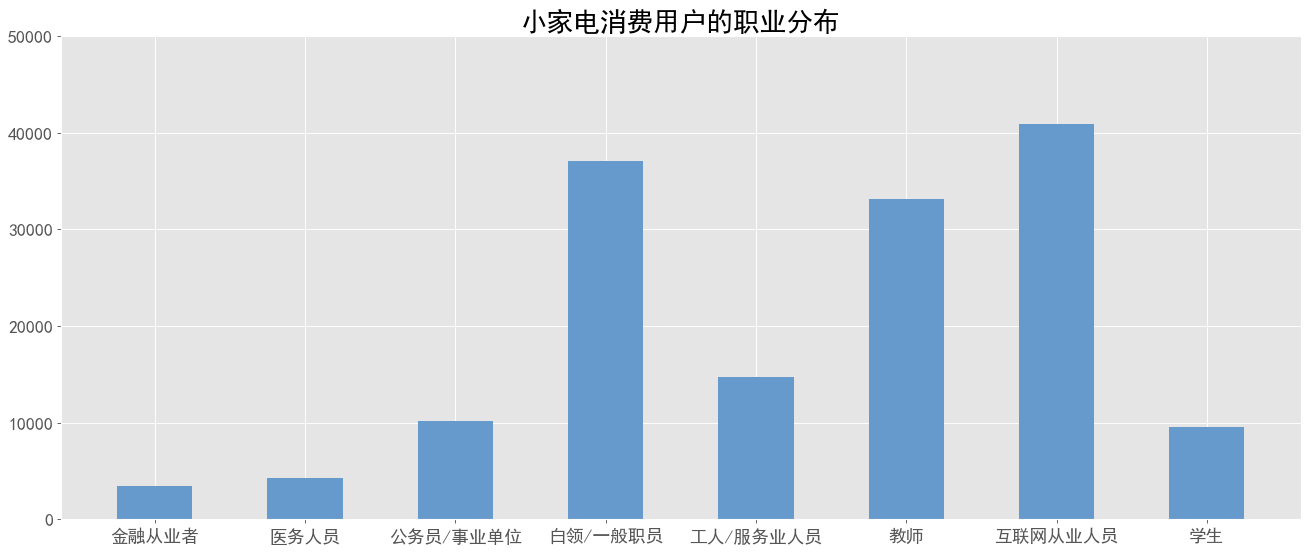

In [65]:
x = ['金融从业者', '医务人员', '公务员/事业单位', '白领/一般职员', '工人/服务业人员', '教师', '互联网从业人员', '学生']
y = user_profession_df['profession']

plt.figure(figsize=(20,8),dpi=80)
plt.style.use('ggplot')
plt.ylim(ymax=50000) # y轴坐标最大值设为50000
plt.title("小家电消费用户的职业分布", size=24)

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.bar(x, y, width=0.5, color='#6699CC')

## 用户收入

无法获取该部分数据

In [66]:
user_info_df.groupby("ulp_base_income", as_index = False)["user_log_acct"].agg({"income" : "count"})

,ulp_base_income,income
0,-1,215090


## 是否有车

In [67]:
user_car_df = user_info_df.groupby("ulp_seni_hascar", as_index = False)["user_log_acct"].agg({"car_count":"count"})
user_car_df

,ulp_seni_hascar,car_count
0,-1,114522
1,0,30974
2,1,69594


In [68]:
user_car_df = user_car_df[user_car_df.ulp_seni_hascar >="0"]
user_car_df

,ulp_seni_hascar,car_count
1,0,30974
2,1,69594


In [69]:
# 统计人数
have_car = user_car_df["car_count"][1]
no_car = user_car_df["car_count"][2]
total_user = have_car+no_car

# 百分比
user_car_df["percent"] = user_car_df["car_count"]/total_user
user_car_df

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,ulp_seni_hascar,car_count,percent
1,0,30974,0.307991
2,1,69594,0.692009


Text(0.5, 1.0, '小家电消费用户私家车拥有率')

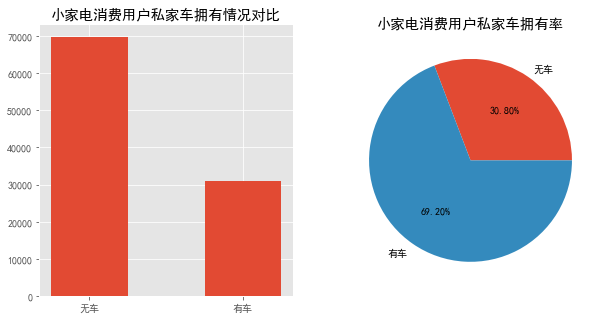

In [70]:
labels = ["无车", "有车"]
plt.figure(figsize = (10,5))

# 柱状图
plt.subplot(121)
plt.bar(labels,[no_car,have_car],width = 0.5)
plt.title("小家电消费用户私家车拥有情况对比")

# 饼图
plt.subplot(122)
plt.pie(user_car_df["percent"],labels = labels, autopct='%1.2f%%')
plt.xticks(size = 14)
plt.title("小家电消费用户私家车拥有率")

## 小家电消费用户画像-基本属性总结

**一位典型小家电消费用户画像：**

他是一位30岁左右的男士，来自一线或新一线城市；

他有着本科学历，在互联网公司就职或是其他行业白领；

他已婚并且有了孩子，孩子在3岁以下；

有一辆代步车；

**推测**

他应该拥比较追求生活品质，注重家庭观念。

但是一线城市节奏快，生活压力大，他可能缺少时间和精力来关注家庭生活。

**结论**

促销的文案可以采用比较中性的风格，突出促销产品对于家庭生活品质的提升。

# 消费属性

## 近3个月客单价

In [71]:
pctatm_df = order_user_df.groupby("ulp_tmsale_3m_pctatm",as_index = False)["user_log_acct"].agg({"pctatm_count":"count"})
pctatm_df["ulp_tmsale_3m_pctatm"] = pd.to_numeric(pctatm_df["ulp_tmsale_3m_pctatm"], errors='coerce')
pctatm_df

,ulp_tmsale_3m_pctatm,pctatm_count
0,0.0,70206
1,0.1,29
2,0.5,2
3,0.6,10
4,0.9,6
...,...,...
18387,999.6,6
18388,999.7,14
18389,999.8,9
18390,999.9,4


In [72]:
pctatm_df.describe()

,ulp_tmsale_3m_pctatm,pctatm_count
count,18392.000000,18392.000000
mean,1324.581013,33.042192
std,2560.005979,522.362072
min,0.000000,1.000000
25%,461.675000,2.000000
50%,932.850000,8.000000
75%,1606.725000,28.000000
max,202203.100000,70206.000000


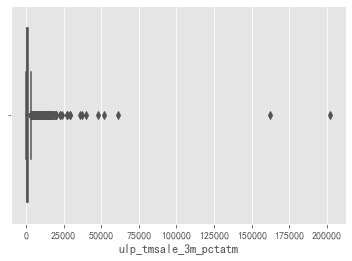

In [73]:
sns.boxplot(pctatm_df["ulp_tmsale_3m_pctatm"])

In [74]:
bins = [-1,0, 100, 500, 1000, 1500, max(pctatm_df["ulp_tmsale_3m_pctatm"])]
labels = ["0元","100元以下","100-500元","500-1000元","1000-1500元","1500以上"]
pctatm_df["pctatm_range"] = pd.cut(pctatm_df["ulp_tmsale_3m_pctatm"],bins, labels = labels)

In [75]:
pctatm_df2 = pctatm_df.groupby("pctatm_range",as_index = False)["pctatm_count"].agg({"total_count":"sum"})
pctatm_df2

,pctatm_range,total_count
0,0元,70206
1,100元以下,103244
2,100-500元,331157
3,500-1000元,61112
4,1000-1500元,19722
5,1500以上,22271


<BarContainer object of 6 artists>

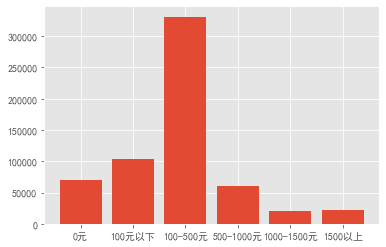

In [76]:
plt.bar(x = pctatm_df2["pctatm_range"], height = pctatm_df2["total_count"])

## 小家电(三级商品)购买情况

In [77]:
# 订单维度的分析， 使用的是有效订单

vaild_order_user_df = order_user_df[(order_user_df['sale_ord_valid_flag'] == 1)
                          &(order_user_df['cancel_flag'] == 0)
                          &(order_user_df['check_account_tm'] != 0)
                          &(order_user_df['before_prefr_unit_price'] != 0)
                          &(order_user_df['user_actual_pay_amount'] != 0)] # 筛选有效订单
vaild_order_user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232599 entries, 9 to 607711
Data columns (total 65 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   user_log_acct            232599 non-null  object        
 1   parent_sale_ord_id       232599 non-null  object        
 2   sale_ord_id              232599 non-null  object        
 3   sale_ord_tm              232599 non-null  datetime64[ns]
 4   sale_ord_dt              232599 non-null  datetime64[ns]
 5   item_sku_id              232599 non-null  object        
 6   item_name                232599 non-null  object        
 7   brandname                232599 non-null  object        
 8   sale_qtty                232599 non-null  int32         
 9   item_first_cate_name     232599 non-null  object        
 10  item_second_cate_name    232599 non-null  object        
 11  item_third_cate_name     232599 non-null  object        
 12  before_prefr_uni

In [78]:
vaild_order_user_df["cvl_glob_values"] = vaild_order_user_df["cvl_glob_values"].astype(float)
vaild_order_user_df["cvl_glob_platform"] = vaild_order_user_df["cvl_glob_platform"].astype(float)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
# 三级商品
user_order_cate_df = vaild_order_user_df.groupby('item_third_cate_name', as_index=False)['sale_ord_id']\
                    .agg({'cate_count':'count'})\
                    .sort_values(by='cate_count', ascending=False)
user_order_cate_df

,item_third_cate_name,cate_count
16,电风扇,74863
2,净水器,39712
20,饮水机,16847
3,加湿器,16240
5,吸尘器,15899
8,挂烫机/熨斗,13008
17,空气净化器,10383
1,冷风扇,9237
7,扫地机器人,8630
15,电话机,6085


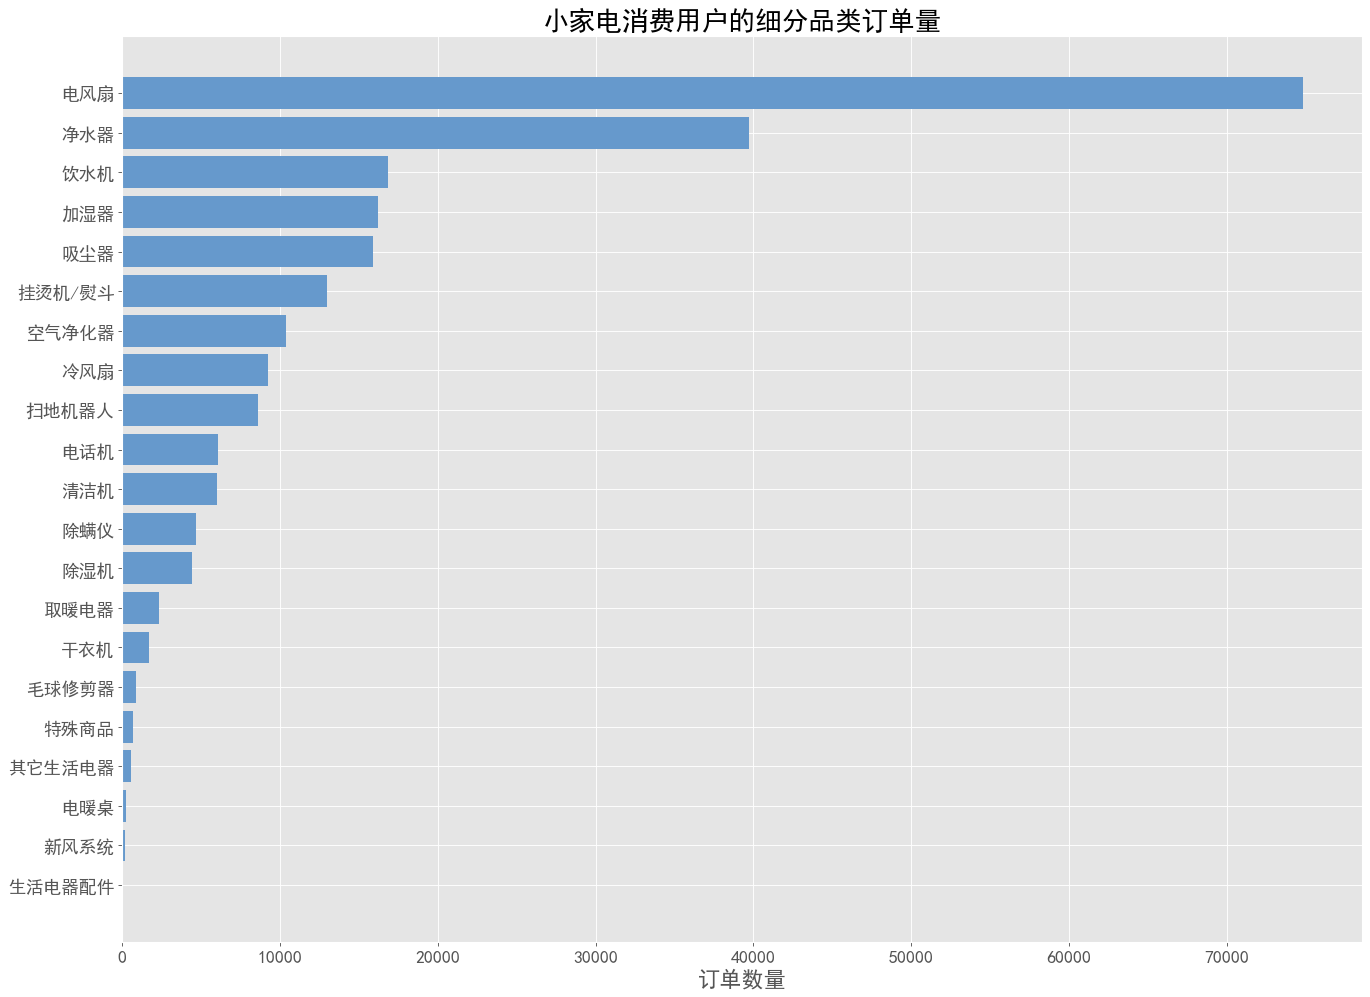

In [80]:
x = user_order_cate_df['item_third_cate_name'][::-1]
y = user_order_cate_df['cate_count'][::-1]

plt.figure(figsize=(20,15),dpi=80)
plt.xlabel('订单数量', size=20)
plt.barh(x, y, align='center', color='#6699CC')
plt.title("小家电消费用户的细分品类订单量", size=24)

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.show()

## 时间维度拆分订单数据

In [81]:
# 我们要按星期统计，所以要把时间按照星期几分组
# 先把时间变星期，再按星期分组

vaild_order_user_df_2 = vaild_order_user_df.copy()

# 将订单日期转化为星期，数字0—6，依次代表周日、周一、周二、周三、周四、周五、周六
vaild_order_user_df_2['order_time_week'] = vaild_order_user_df_2['sale_ord_tm'].apply(lambda x: x.strftime('%w'))
vaild_order_user_df_2

,user_log_acct,parent_sale_ord_id,sale_ord_id,sale_ord_tm,sale_ord_dt,item_sku_id,item_name,brandname,sale_qtty,item_first_cate_name,...,cvl_glob_loyalty,cvl_glob_platform,cfv_sens_promotion,cfv_sens_comment,reg_user_type_cd,member_reg_gender,reg_birthday,last_login_tm,factory_user_flag,order_time_week
9,---刺猬,130744622338,124941786367,2020-08-18 18:11:35,2020-08-18,100001679413,安吉尔（Angel）茶吧机立式家用办公室饮水机多功能自动上水柜式茶吧机下置水桶式CB2705...,安吉尔（Angel）,1,家用电器,...,高度-忠诚型,79.137988,L1-2,L1-5,NaN,2,NaN,2019-12-11 18:29:44.0,1,2
12,--寂,124775599894,124776112766,2020-08-15 12:49:06,2020-08-15,2392546,赛亿（Shinee）小风扇 台扇/台夹扇 壁扇 迷你静音学生宿舍床头办公室桌面换气电风扇FJ...,赛亿（Shinee）,1,家用电器,...,高度-忠诚型,-1.000000,L1-4,L1-5,NaN,2,NaN,2020-02-25 15:01:41.0,1,6
16,-zhongzhong,124778603709,130550058117,2020-08-15 12:53:08,2020-08-15,100012373764,格力 （GREE）新品家用智能遥控定时电风扇/塔式落地扇/直流变频电扇/立式塔扇/无叶风扇F...,格力（GREE）,1,家用电器,...,高度-忠诚型,63.646321,L1-3,L1-5,NaN,0,1986-10-22,2020-08-12 14:24:47.0,1,6
20,-万春强,130510311878,130510311878,2020-08-14 18:32:41,2020-08-14,4730589,碧然德（BRITA）滤水壶滤芯 Maxtra+多效滤芯8只装 过滤净水器滤芯 家用滤水壶滤芯...,碧然德,1,家用电器,...,高度-忠诚型,70.887699,L1-4,L1-5,NaN,0,1968-2-2,2020-03-20 08:08:27.0,1,5
21,-古奈-,124710975645,124709548404,2020-08-14 09:28:55,2020-08-14,100006623913,爱丽思(IRIS)日本 电风扇/空气循环扇/台扇 办公桌家用台式静音迷你小风扇PCF-HEK15白,爱丽思（IRIS）,1,家用电器,...,高度-忠诚型,97.073390,L1-4,L1-5,NaN,2,NaN,2019-02-22 10:50:12.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607702,龙飞凤舞0723,130739569871,124990189784,2020-08-19 13:22:12,2020-08-19,67823962060,格力(GREE)塔式冷风扇空调扇水冷塔扇遥控冷风机家用静音制冷机器电风扇冷气扇单冷水空调移动...,格力（GREE）,1,家用电器,...,高度-忠诚型,-1.000000,L1-4,L1-5,NaN,2,NaN,2020-01-13 11:24:26.0,1,3
607706,龚凤波,124863599292,124863599292,2020-08-17 08:13:19,2020-08-17,100005221904,康佳（KONKA）大型家用商用空调扇 制冷风扇 冷风机 冷风扇 车间食堂餐厅网吧大排档移动工...,康佳（KONKA）,1,家用电器,...,高度-忠诚型,-1.000000,L1-2,L1-3,1,2,NaN,2017-04-28 14:18:32.0,0,1
607707,龚天睿,124772876191,124772404564,2020-08-15 11:03:24,2020-08-15,5149351,碧然德（BRITA）家用净水壶 滤水壶滤芯 MAXTRA+LE 去水垢专家滤芯 3枚装,碧然德,1,家用电器,...,高度-忠诚型,74.562119,L1-4,L1-5,NaN,0,2011-1-1,2019-12-04 22:35:59.0,1,6
607710,龚思嘉,124875168188,124875168188,2020-08-17 12:35:34,2020-08-17,4460778,沁园（TRULIVA）家用净水器 即滤型超滤机 长寿命滤芯 无废水 矿物质净水机 QJ-UF...,沁园（TRULIVA）,1,家用电器,...,高度-忠诚型,15.897320,L1-4,L1-5,NaN,0,0001-1-1,2019-11-02 09:57:09.0,1,1


In [82]:
# 星期
user_order_week_df = vaild_order_user_df_2.groupby('order_time_week', as_index=False)['sale_ord_id'].\
                                agg({'week_count':'count'}).sort_values(by='order_time_week', ascending=True)
user_order_week_df

,order_time_week,week_count
0,0,30201
1,1,29688
2,2,43686
3,3,21570
4,4,25485
5,5,30394
6,6,51575


In [83]:
user_order_week_df[0:1] # 0是周日

,order_time_week,week_count
0,0,30201


In [84]:
user_order_week_df[1:] # 1-6是周一到周六

,order_time_week,week_count
1,1,29688
2,2,43686
3,3,21570
4,4,25485
5,5,30394
6,6,51575


In [85]:
# 两个dataframe上下拼接，也就是把后面的dataframe，追加到前面dataframe的末尾
user_order_week_df_2 = user_order_week_df[1:].append(user_order_week_df[0:1])
user_order_week_df_2

,order_time_week,week_count
1,1,29688
2,2,43686
3,3,21570
4,4,25485
5,5,30394
6,6,51575
0,0,30201


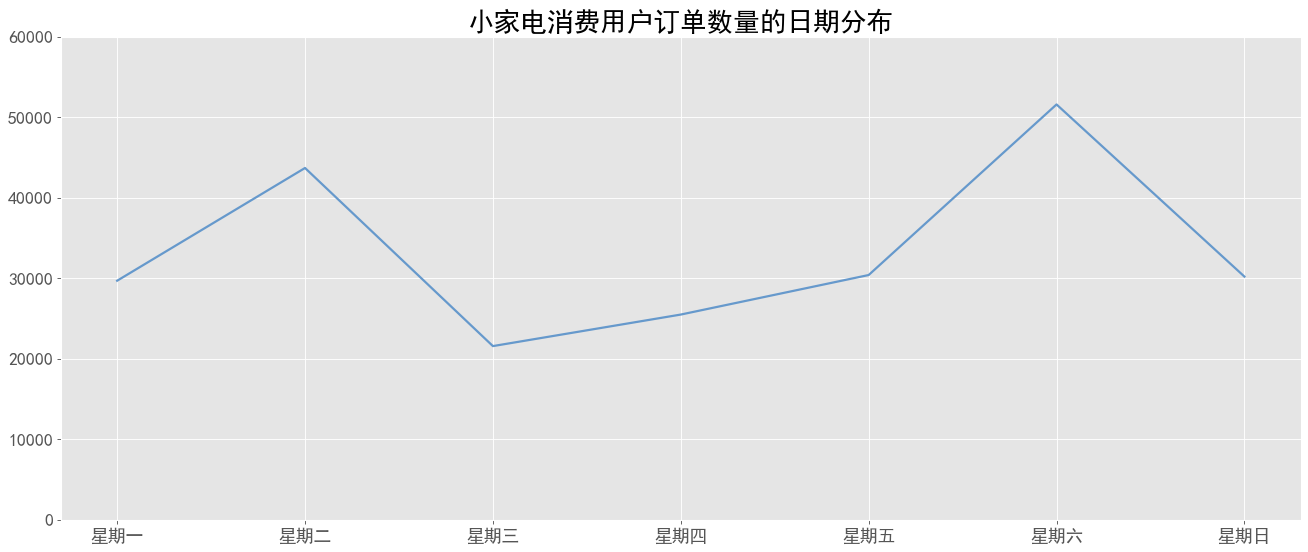

In [88]:
x = ['星期一', '星期二', '星期三', '星期四', '星期五', '星期六', '星期日']
y = user_order_week_df_2['week_count']

plt.figure(figsize=(20,8),dpi=80)
plt.style.use('ggplot')

plt.ylim(ymin=0,ymax=60000) # y轴坐标，最小值0.最大值设为60000
plt.title("小家电消费用户订单数量的日期分布", size=24)

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.plot(x, y, linewidth=2.0, color='#6699CC', linestyle='-')

## 小家电消费用户订单数量的时间分布

In [89]:
# 把订单时间只保留小时
vaild_order_user_df_2['order_time_hms'] = vaild_order_user_df_2['sale_ord_tm']\
                                            .apply(lambda x: x.strftime('%H:00:00'))
vaild_order_user_df_2

,user_log_acct,parent_sale_ord_id,sale_ord_id,sale_ord_tm,sale_ord_dt,item_sku_id,item_name,brandname,sale_qtty,item_first_cate_name,...,cvl_glob_platform,cfv_sens_promotion,cfv_sens_comment,reg_user_type_cd,member_reg_gender,reg_birthday,last_login_tm,factory_user_flag,order_time_week,order_time_hms
9,---刺猬,130744622338,124941786367,2020-08-18 18:11:35,2020-08-18,100001679413,安吉尔（Angel）茶吧机立式家用办公室饮水机多功能自动上水柜式茶吧机下置水桶式CB2705...,安吉尔（Angel）,1,家用电器,...,79.137988,L1-2,L1-5,NaN,2,NaN,2019-12-11 18:29:44.0,1,2,18:00:00
12,--寂,124775599894,124776112766,2020-08-15 12:49:06,2020-08-15,2392546,赛亿（Shinee）小风扇 台扇/台夹扇 壁扇 迷你静音学生宿舍床头办公室桌面换气电风扇FJ...,赛亿（Shinee）,1,家用电器,...,-1.000000,L1-4,L1-5,NaN,2,NaN,2020-02-25 15:01:41.0,1,6,12:00:00
16,-zhongzhong,124778603709,130550058117,2020-08-15 12:53:08,2020-08-15,100012373764,格力 （GREE）新品家用智能遥控定时电风扇/塔式落地扇/直流变频电扇/立式塔扇/无叶风扇F...,格力（GREE）,1,家用电器,...,63.646321,L1-3,L1-5,NaN,0,1986-10-22,2020-08-12 14:24:47.0,1,6,12:00:00
20,-万春强,130510311878,130510311878,2020-08-14 18:32:41,2020-08-14,4730589,碧然德（BRITA）滤水壶滤芯 Maxtra+多效滤芯8只装 过滤净水器滤芯 家用滤水壶滤芯...,碧然德,1,家用电器,...,70.887699,L1-4,L1-5,NaN,0,1968-2-2,2020-03-20 08:08:27.0,1,5,18:00:00
21,-古奈-,124710975645,124709548404,2020-08-14 09:28:55,2020-08-14,100006623913,爱丽思(IRIS)日本 电风扇/空气循环扇/台扇 办公桌家用台式静音迷你小风扇PCF-HEK15白,爱丽思（IRIS）,1,家用电器,...,97.073390,L1-4,L1-5,NaN,2,NaN,2019-02-22 10:50:12.0,1,5,09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607702,龙飞凤舞0723,130739569871,124990189784,2020-08-19 13:22:12,2020-08-19,67823962060,格力(GREE)塔式冷风扇空调扇水冷塔扇遥控冷风机家用静音制冷机器电风扇冷气扇单冷水空调移动...,格力（GREE）,1,家用电器,...,-1.000000,L1-4,L1-5,NaN,2,NaN,2020-01-13 11:24:26.0,1,3,13:00:00
607706,龚凤波,124863599292,124863599292,2020-08-17 08:13:19,2020-08-17,100005221904,康佳（KONKA）大型家用商用空调扇 制冷风扇 冷风机 冷风扇 车间食堂餐厅网吧大排档移动工...,康佳（KONKA）,1,家用电器,...,-1.000000,L1-2,L1-3,1,2,NaN,2017-04-28 14:18:32.0,0,1,08:00:00
607707,龚天睿,124772876191,124772404564,2020-08-15 11:03:24,2020-08-15,5149351,碧然德（BRITA）家用净水壶 滤水壶滤芯 MAXTRA+LE 去水垢专家滤芯 3枚装,碧然德,1,家用电器,...,74.562119,L1-4,L1-5,NaN,0,2011-1-1,2019-12-04 22:35:59.0,1,6,11:00:00
607710,龚思嘉,124875168188,124875168188,2020-08-17 12:35:34,2020-08-17,4460778,沁园（TRULIVA）家用净水器 即滤型超滤机 长寿命滤芯 无废水 矿物质净水机 QJ-UF...,沁园（TRULIVA）,1,家用电器,...,15.897320,L1-4,L1-5,NaN,0,0001-1-1,2019-11-02 09:57:09.0,1,1,12:00:00


In [90]:
user_order_hms_df = vaild_order_user_df_2.groupby('order_time_hms', as_index=False)['sale_ord_id'].\
                                agg({'hms_count':'count'}).sort_values(by='order_time_hms', ascending=True)
user_order_hms_df

,order_time_hms,hms_count
0,00:00:00,13212
1,01:00:00,4087
2,02:00:00,1919
3,03:00:00,1242
4,04:00:00,892
5,05:00:00,1216
6,06:00:00,3052
7,07:00:00,5946
8,08:00:00,10058
9,09:00:00,13550


In [224]:
# 生成时间标签
hour_list = [x for x in range(0, 24)]
#hour_list

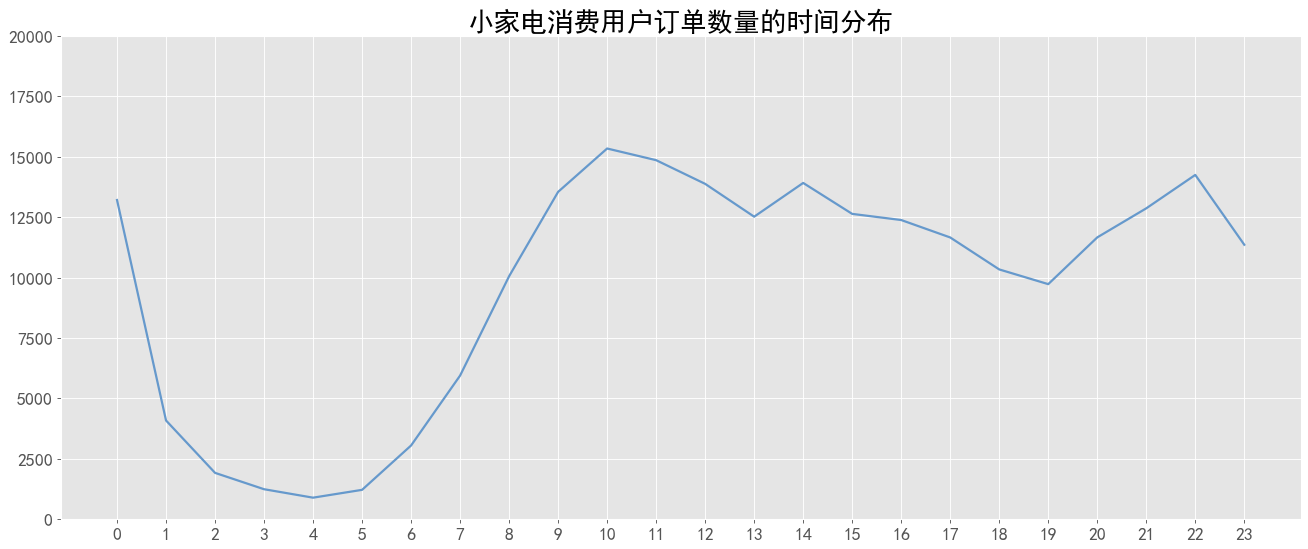

In [92]:
x = hour_list
y = user_order_hms_df['hms_count']

plt.figure(figsize=(20,8),dpi=80)
plt.style.use('ggplot')

plt.ylim(ymin=0,ymax=20000) # y轴坐标，最小值0.最大值设为20000
plt.title("小家电消费用户订单数量的时间分布", size=24)

plt.xticks(x, size=16) # x轴显示内容及字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.plot(x, y, linewidth=2.0, color='#6699CC', linestyle='-', clip_on=False)

## 客单价

In [179]:
# 计算单笔订单支付总价
vaild_order_user_df["total_pay"] = vaild_order_user_df["user_actual_pay_amount"]* vaild_order_user_df["sale_qtty"]
vaild_order_user_df["total_pay"].describe()

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    2.325990e+05
mean     2.080458e+03
std      9.227130e+04
min      1.000000e-02
25%      7.900000e+01
50%      1.690000e+02
75%      3.989800e+02
max      2.384640e+07
Name: total_pay, dtype: float64

In [200]:
# 因为有很多订单是1毛，属于“抢先”、“体验”，还有很多超低价的单子，所以把10块以下的单子都去掉
vaild_order_user_df3 = vaild_order_user_df[vaild_order_user_df.total_pay >=10]

In [201]:
# 按照地域，分别统计用户数和订单数
user_and_order_df = vaild_order_user_df3.groupby("ulp_addr_province",as_index = True)[["user_log_acct","sale_ord_id"]].nunique()
user_and_order_df = user_and_order_df.reset_index()
user_and_order_df = user_and_order_df[user_and_order_df.ulp_addr_province != "-1"]
user_and_order_df = user_and_order_df.sort_values(by = "user_log_acct", ascending = False)
user_and_order_df

,ulp_addr_province,user_log_acct,sale_ord_id
12,广东,29295,34819
4,北京,16060,18824
15,江苏,15873,18402
1,上海,12106,14163
10,山东,11693,13612
6,四川,9120,10260
21,湖北,7833,9368
19,浙江,7563,8990
17,河北,6408,7324
27,辽宁,5777,6586


In [202]:
# 按照地域，计算GMV
user_pay = vaild_order_user_df3.groupby("ulp_addr_province",as_index = False)["total_pay"].sum()
user_pay = user_pay[user_pay.ulp_addr_province != "-1"]
user_pay

,ulp_addr_province,total_pay
1,上海,1.169828e+07
2,云南,2.196933e+06
3,内蒙古,1.800389e+06
4,北京,1.128357e+08
5,吉林,1.377615e+06
6,四川,8.356018e+06
7,天津,4.617241e+06
8,宁夏,3.219859e+05
9,安徽,3.490845e+07
10,山东,3.403536e+07


In [203]:
pay_province = pd.merge(user_and_order_df, user_pay, on = "ulp_addr_province")
pay_province["客单价"] = pay_province["total_pay"]/pay_province["user_log_acct"]
pay_province["平均订单价格"] = pay_province["total_pay"]/pay_province["sale_ord_id"]
pay_province

,ulp_addr_province,user_log_acct,sale_ord_id,total_pay,客单价,平均订单价格
0,广东,29295,34819,1.058484e+08,3613.189484,3039.960537
1,北京,16060,18824,1.128357e+08,7025.883425,5994.246059
2,江苏,15873,18402,2.029130e+07,1278.352988,1102.668024
3,上海,12106,14163,1.169828e+07,966.320983,825.974851
4,山东,11693,13612,3.403536e+07,2910.746849,2500.393983
5,四川,9120,10260,8.356018e+06,916.230080,814.426738
6,湖北,7833,9368,8.578102e+06,1095.123502,915.681297
7,浙江,7563,8990,2.558232e+07,3382.563105,2845.642354
8,河北,6408,7324,1.192863e+07,1861.521846,1628.704532
9,辽宁,5777,6586,1.592873e+07,2757.265884,2418.573491


In [221]:
# 客单价top 10
df1 = pay_province.sort_values(by = "客单价",ascending = False)[:10]
x1 = df1.ulp_addr_province[::-1]
y1 = df1["客单价"][::-1]
df1 

,ulp_addr_province,user_log_acct,sale_ord_id,total_pay,客单价,平均订单价格
30,西藏,199,244,1.610201e+06,8091.463920,6599.185738
18,江西,2363,2848,1.863879e+07,7887.765942,6544.519284
13,安徽,4662,5391,3.490845e+07,7487.869612,6475.319631
1,北京,16060,18824,1.128357e+08,7025.883425,5994.246059
0,广东,29295,34819,1.058484e+08,3613.189484,3039.960537
7,浙江,7563,8990,2.558232e+07,3382.563105,2845.642354
20,贵州,1658,1874,5.326256e+06,3212.458299,2842.185624
4,山东,11693,13612,3.403536e+07,2910.746849,2500.393983
9,辽宁,5777,6586,1.592873e+07,2757.265884,2418.573491
16,广西,3773,4488,9.948367e+06,2636.725987,2216.659347


In [222]:
# 平均订单价格top 10
df2 = pay_province.sort_values(by = "平均订单价格",ascending = False)[:10]
x2 = df1.ulp_addr_province[::-1]
y2 = df1["平均订单价格"][::-1]
df2

,ulp_addr_province,user_log_acct,sale_ord_id,total_pay,客单价,平均订单价格
30,西藏,199,244,1.610201e+06,8091.463920,6599.185738
18,江西,2363,2848,1.863879e+07,7887.765942,6544.519284
13,安徽,4662,5391,3.490845e+07,7487.869612,6475.319631
1,北京,16060,18824,1.128357e+08,7025.883425,5994.246059
0,广东,29295,34819,1.058484e+08,3613.189484,3039.960537
7,浙江,7563,8990,2.558232e+07,3382.563105,2845.642354
20,贵州,1658,1874,5.326256e+06,3212.458299,2842.185624
4,山东,11693,13612,3.403536e+07,2910.746849,2500.393983
9,辽宁,5777,6586,1.592873e+07,2757.265884,2418.573491
14,陕西,4579,5218,1.194270e+07,2608.145086,2288.749780


Text(0.5, 1.0, '各省份平均订单价格')

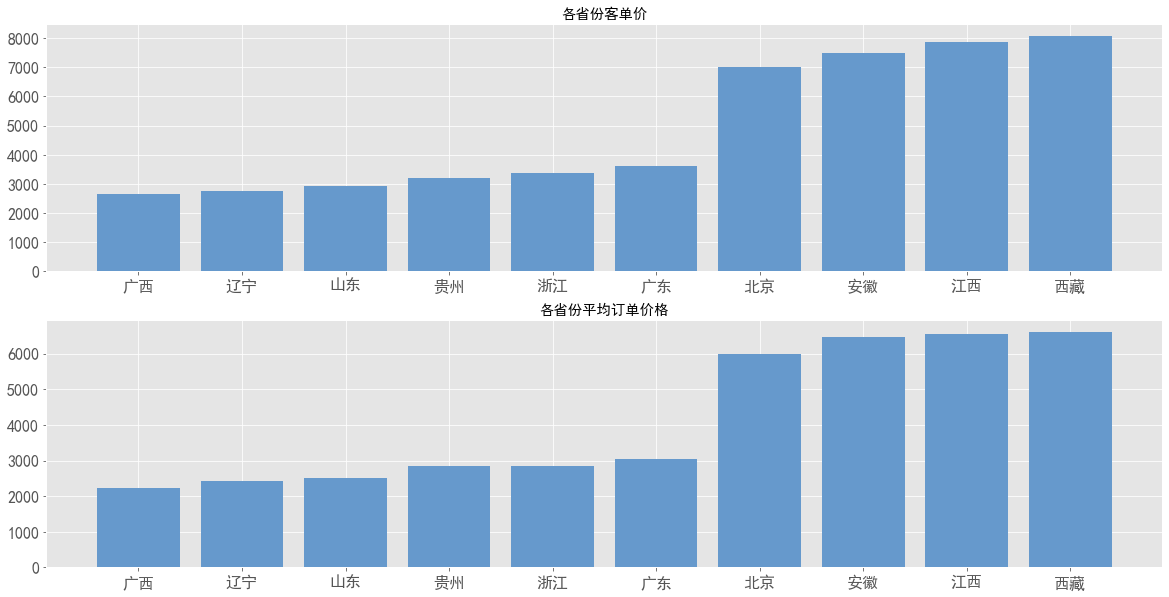

In [223]:
plt.figure(figsize = (20,10))

# 客单价
plt.subplot(211)
plt.bar(x1, y1,color='#6699CC')
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.title("各省份客单价")


# 平均订单价格
plt.subplot(212)
plt.bar(x2, y2, color='#6699CC')
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.title("各省份平均订单价格")

令人非常意外，第一名是西藏、第二名是江西

这些用户似乎更愿意支付更高的价格，可以适当推送高价商品

12	广东	35247
15	江苏	19370
4	北京	19214

## 各省热销top 10

In [ ]:
vaild_order_user_df.info()item_third_cate_name，ulp_addr_province

### 广东

In [230]:
yue_df = vaild_order_user_df[vaild_order_user_df["ulp_addr_province"]=="广东"]
yue_df = yue_df.groupby("item_third_cate_name",as_index = False)["ulp_addr_province"].agg({"nums":"count"})
yue_df = yue_df.sort_values(by = "nums", ascending = False)[:10]
yue_df

,item_third_cate_name,nums
16,电风扇,15472
2,净水器,6831
5,吸尘器,2638
20,饮水机,2125
8,挂烫机/熨斗,1663
3,加湿器,1615
17,空气净化器,1517
7,扫地机器人,1359
15,电话机,1123
1,冷风扇,1020


8月，广州比较热，电风扇成为销量第一的商品，且远超其他类目

### 江苏

In [237]:
su_df = vaild_order_user_df[vaild_order_user_df["ulp_addr_province"]=="江苏"]
su_df = su_df.groupby("item_third_cate_name",as_index = False)["ulp_addr_province"].agg({"nums":"count"})
su_df = su_df.sort_values(by = "nums", ascending = False)[:10]
su_df

,item_third_cate_name,nums
15,电风扇,7727
2,净水器,2872
1,冷风扇,1479
5,吸尘器,1368
16,空气净化器,1091
19,饮水机,1067
3,加湿器,963
8,挂烫机/熨斗,885
7,扫地机器人,704
14,电话机,457


江苏没有广东那么偏南，电风扇的需求下降许多；第二到第十位的商品和广东比较类似

### 北京

In [238]:
jing_df = vaild_order_user_df[vaild_order_user_df["ulp_addr_province"]=="北京"]
jing_df = jing_df.groupby("item_third_cate_name",as_index = False)["ulp_addr_province"].agg({"nums":"count"})
jing_df = jing_df.sort_values(by = "nums", ascending = False)[:10]
jing_df

,item_third_cate_name,nums
2,净水器,5118
16,电风扇,5018
3,加湿器,1981
5,吸尘器,1593
8,挂烫机/熨斗,1545
20,饮水机,1450
17,空气净化器,1243
7,扫地机器人,845
15,电话机,723
18,除湿机,534


可能由于北京更北不那么热的缘故，电风扇的需求又下降了，其他商品和江苏、广东类似

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text yticklabel objects>)

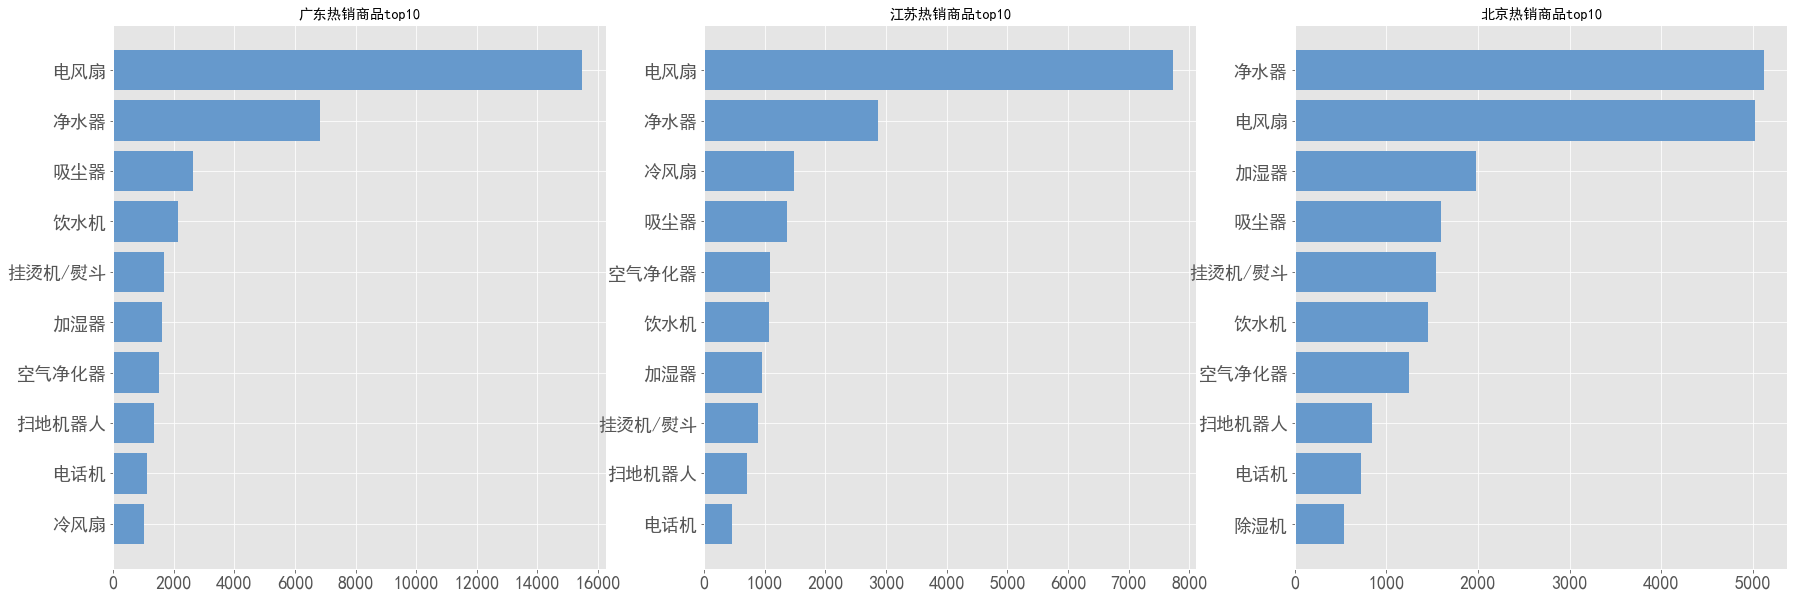

In [245]:
plt.figure(figsize = (30,10))

# 广东
plt.subplot(131)
x1 = yue_df["item_third_cate_name"][::-1]
y1 = yue_df["nums"][::-1]
plt.barh(x1,y1,color = b)
plt.title("广东热销商品top10")
plt.xticks(size = 18)
plt.yticks(size = 18)

# 江苏
plt.subplot(132)
x2 = su_df["item_third_cate_name"][::-1]
y2 = su_df["nums"][::-1]
plt.barh(x2,y2,color = b)
plt.title("江苏热销商品top10")
plt.xticks(size = 18)
plt.yticks(size = 18)

# 北京
plt.subplot(133)
x3 = jing_df["item_third_cate_name"][::-1]
y3 = jing_df["nums"][::-1]
plt.barh(x3,y3,color = b)
plt.title("北京热销商品top10")
plt.xticks(size = 18)
plt.yticks(size = 18)

因为地理、风俗、习惯等原因，每个省都有自己的习惯，要根据x

# 行为属性

## 小家电消费用户的加购次数分布

In [137]:
# 加购数据用的是xjd_user_cart

user_cart_df.head()

,user_log_acct,item_sku_id,item_cate1_name,item_cate2_name,item_cate3_name,brand_name,main_brand_name,addcart_cnt,delcart_cnt,addcart_flag,delcart_flag,success_addcart_flag,addcart_modify_flag,afterord_delcart_flag,concern_cnt,dt
0,-万春强,100005514432,家用电器,生活电器,净水器,碧然德,碧然德,0,1,0,1,0,0,0,0,2020-08-19
1,-万春强,100004920782,家用电器,生活电器,净水器,小米（MI）,小米（MI）,0,1,0,1,0,0,0,0,2020-08-19
2,-万春强,2823062,家用电器,生活电器,净水器,碧然德,碧然德,0,1,0,1,0,0,0,0,2020-08-19
3,-万春强,68389838720,手机通讯,手机,手机,华为（HUAWEI）,华为（HUAWEI）,1,0,1,0,0,0,0,0,2020-08-15
4,-万春强,67150903788,家用电器,厨房小电,电饼铛,苏泊尔（SUPOR）,苏泊尔（SUPOR）,2,1,1,1,0,1,0,0,2020-08-19


In [138]:
user_cart_df.shape

(3810530, 16)

In [139]:
user_cart_df['addcart_cnt'] = user_cart_df['addcart_cnt'].astype('int')
user_cart_df['addcart_flag'] = user_cart_df['addcart_flag'].astype('int')

In [140]:
# 筛选条件：加购次数>0 且 有效加购标志=1
user_cart_df = user_cart_df[(user_cart_df['addcart_cnt']>0) & (user_cart_df['addcart_flag']==1)]

In [143]:
user_cart_item_cate2_df = user_cart_df.groupby('item_cate2_name', as_index=False)['user_log_acct']\
                                .agg({'addcart_count':'nunique'})\
                                .sort_values(by='addcart_count', ascending=False)
user_cart_item_cate2_df

,item_cate2_name,addcart_count
277,生活电器,148055
99,厨房小电,28472
312,粮油调味,23926
4,个护健康,22400
401,饮料冲调,21691
...,...,...
379,钟表服务,1
387,陶瓷/玉器,1
195,收藏工具,1
239,油动/电动模型,1


In [144]:
# 因为本身这些用户都是购买了小家电的用户，所以他们都会有小家电（也就是生活电器）类的加购
# 所以这里要把生活电器类的一项去掉

user_cart_item_cate2_df.drop([277], inplace=True)
user_cart_item_cate2_df

,item_cate2_name,addcart_count
99,厨房小电,28472
312,粮油调味,23926
4,个护健康,22400
401,饮料冲调,21691
126,大 家 电,20920
...,...,...
379,钟表服务,1
387,陶瓷/玉器,1
195,收藏工具,1
239,油动/电动模型,1


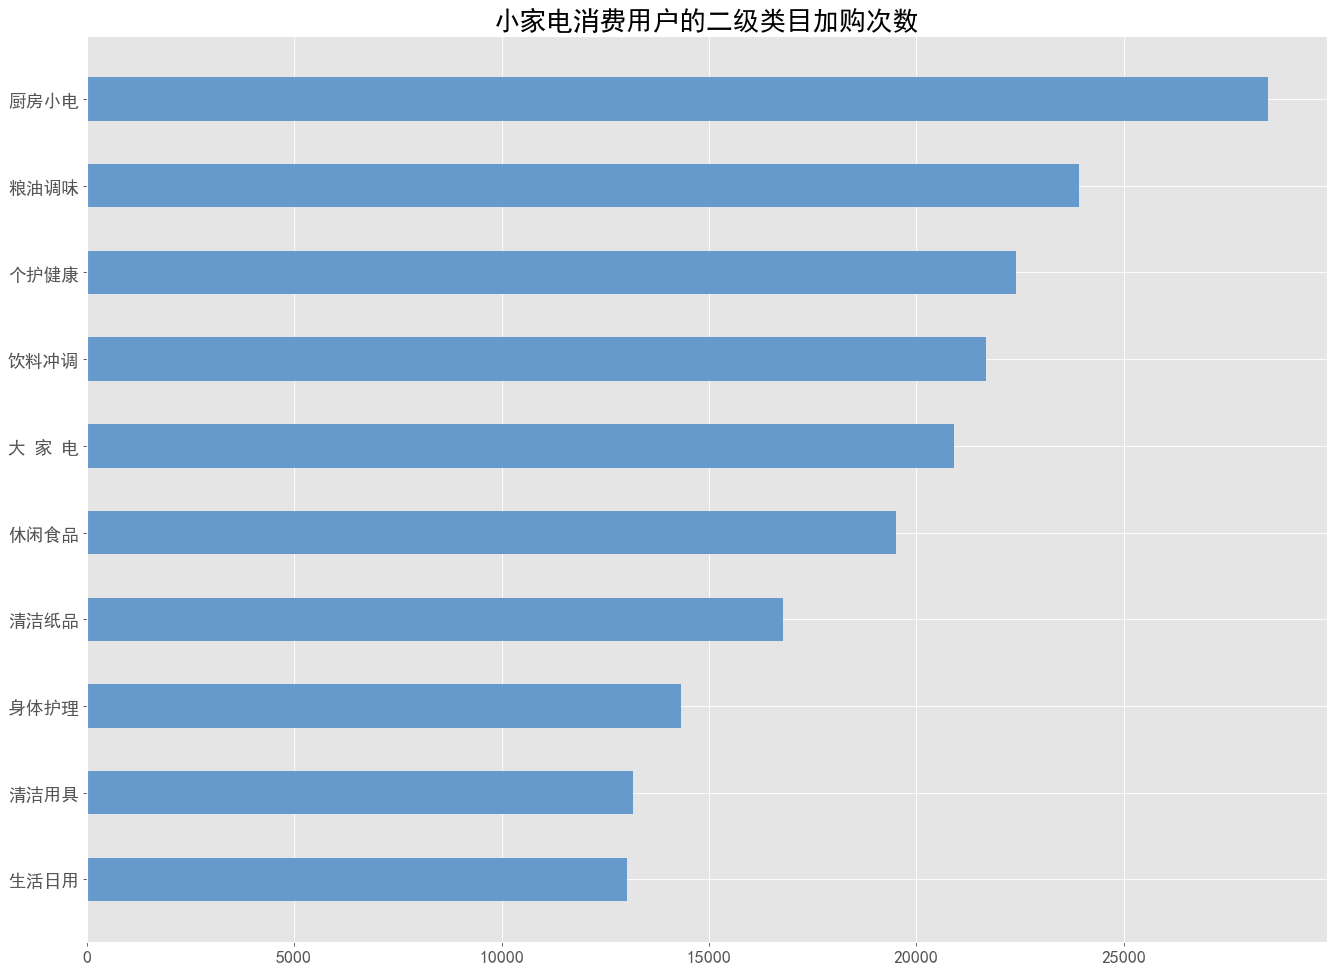

In [146]:
# top 10 截断
x = user_cart_item_cate2_df['item_cate2_name'][:10]
y = user_cart_item_cate2_df['addcart_count'][:10]

x = x[::-1] # 将x反向
y = y[::-1] # 将y反向

plt.figure(figsize=(20,15),dpi=80)

plt.title("小家电消费用户的二级类目加购次数", size=24)

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.barh(x, y, height=0.5, align='center', color='#6699CC')
plt.show()

## 小家电消费用户的三级类目加购次数--厨房小电

In [147]:
user_cart_item_cate3_df = user_cart_df[(user_cart_df['item_cate2_name']=='厨房小电')]
user_cart_item_cate3_df = user_cart_item_cate3_df.groupby('item_cate3_name', as_index=False)['user_log_acct']\
                                .agg({'addcart_count':'nunique'})\
                                .sort_values(by='addcart_count', ascending=False)
user_cart_item_cate3_df

,item_cate3_name,addcart_count
14,电水壶/热水瓶,5698
21,电饭煲,4712
23,破壁机,4064
24,空气炸锅,3639
5,多用途锅,3550
22,电饼铛,2713
6,微波炉,2396
13,电压力锅,2077
1,养生壶/煎药壶,2055
19,电磁炉,1984


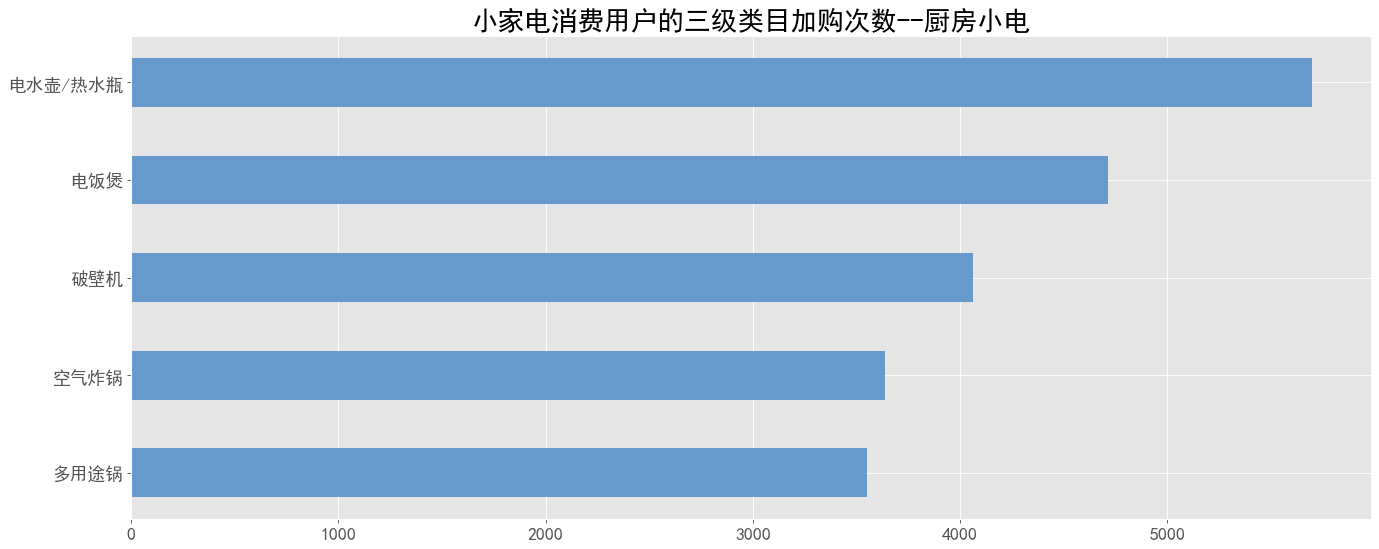

In [148]:
x = user_cart_item_cate3_df['item_cate3_name'][:5][::-1]
y = user_cart_item_cate3_df['addcart_count'][:5][::-1]

plt.figure(figsize=(20,8),dpi=80)

plt.title("小家电消费用户的三级类目加购次数--厨房小电", size=24)

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整
plt.barh(x, y, height=0.5, align='center', color='#6699CC')

plt.show()

其中，top 5的商品一部分也不是生活必需品，属于能提升生活质量的商品，比如破壁机和空气炸锅

## 以厨房小电为例，统计品牌

In [171]:
def brand_count(cate3_name, topn):
    # prepare dataframe
    temp_df = user_cart_df[user_cart_df["item_cate3_name"]== cate3_name]
    brand_df = temp_df.groupby("brand_name", as_index=False)['user_log_acct'].agg(
        {'addcart_count': 'nunique'}).sort_values(by="addcart_count", ascending=False)
    
    # prepare labels
    x = brand_df["brand_name"][:topn][::-1]
    width = brand_df["addcart_count"][:topn][::-1]
    
    # plot graph
    plt.figure(figsize = (20,8))
    plt.barh(x, width,color ="#6699CC" )
    plt.title(cate3_name)
    plt.xticks(size=16) # x轴字体大小调整
    plt.yticks(size=16) # y轴字体大小调整

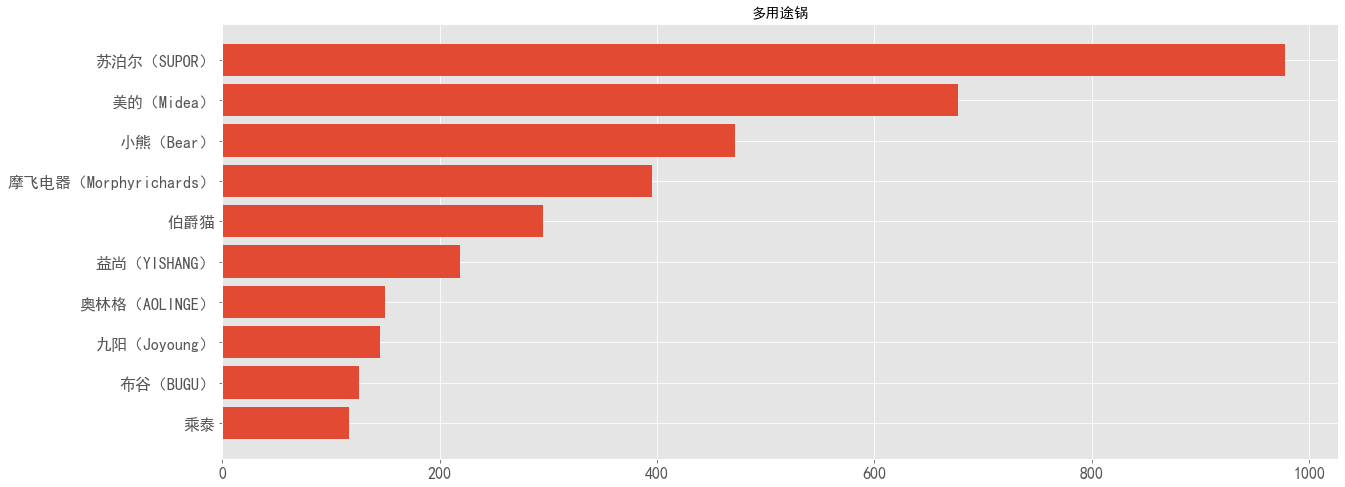

In [170]:
brand_count("多用途锅", 10)

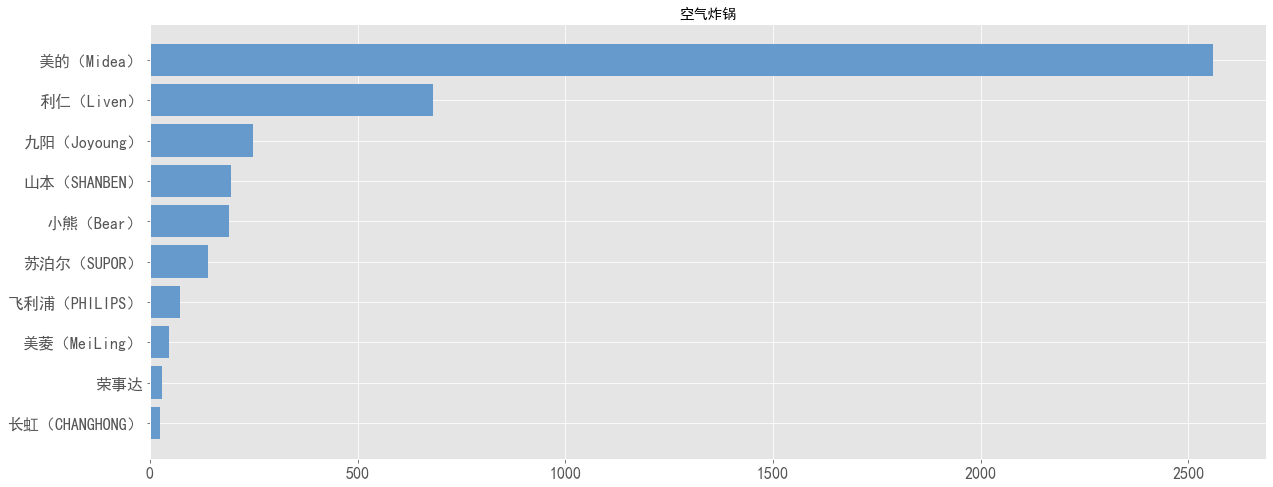

In [172]:
brand_count("空气炸锅", 10)

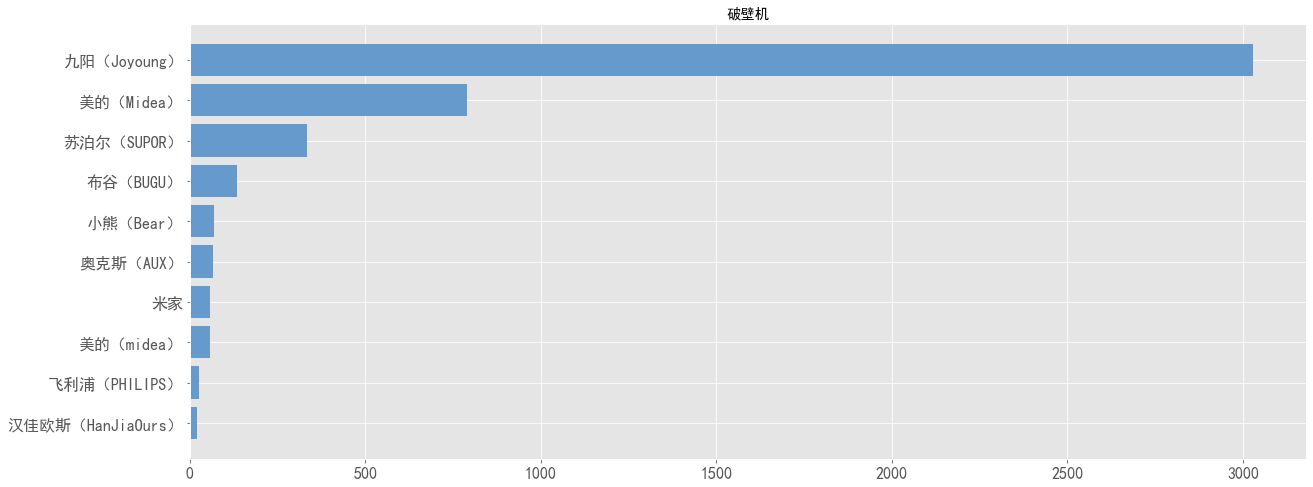

In [173]:
brand_count("破壁机", 10)

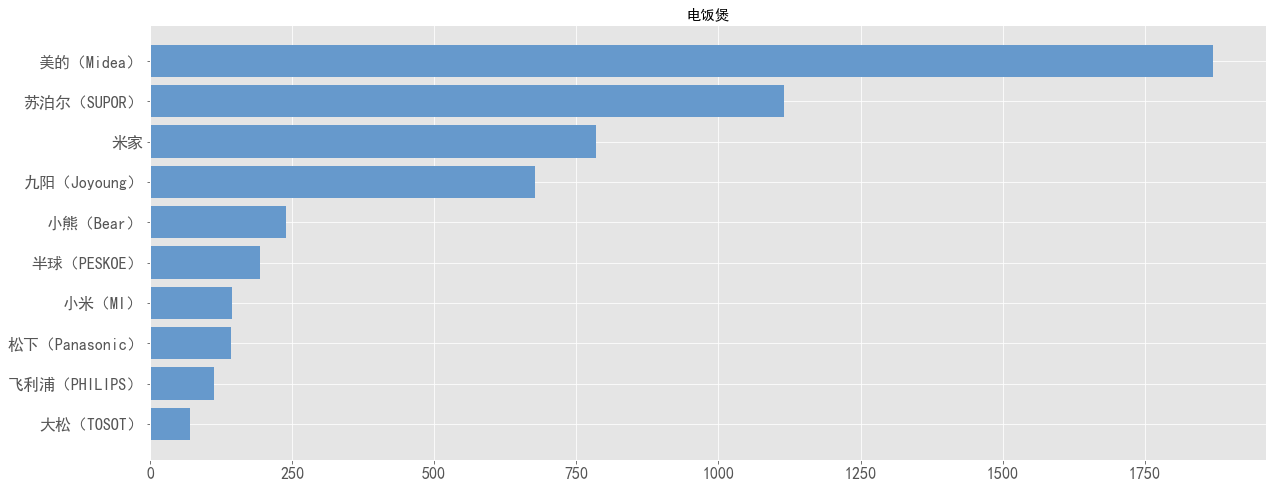

In [174]:
brand_count("电饭煲", 10)

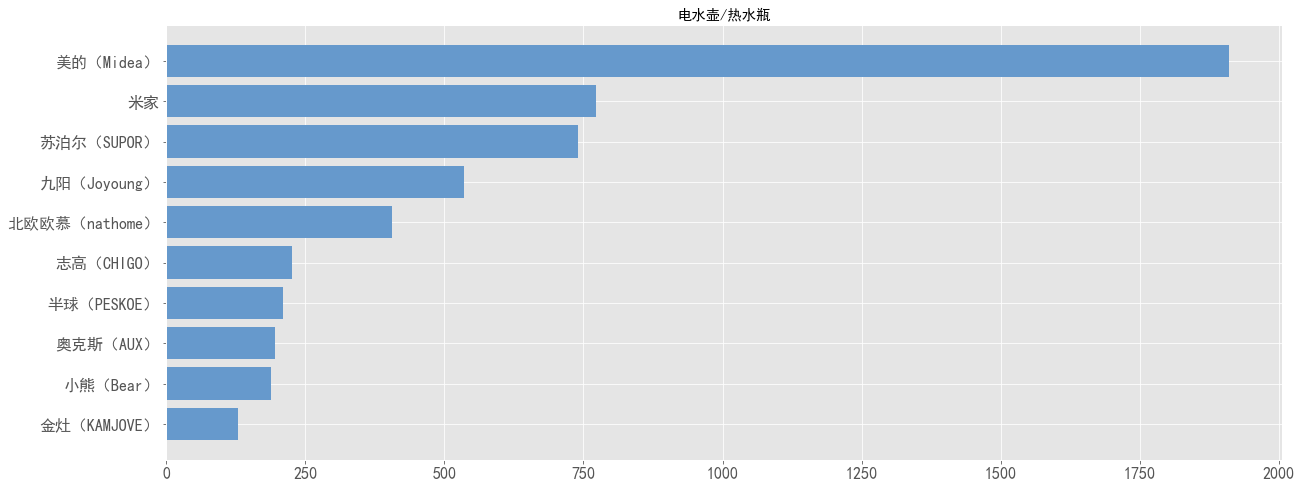

In [175]:
brand_count("电水壶/热水瓶", 10)

正如预期的，厨房小电加购最多的商品更倾向于知名品牌，如美的、苏泊尔

# 用户价值属性

使用了用户有效订单，vaild_order_user_df

其实用user_order_info也许会更好，针对的范围更全面

## 是否曾经是plus会员 

In [93]:
plus_user_df = vaild_order_user_df.groupby("ulp_plus_used", as_index = False)["user_log_acct"].agg({"plus_count":"count"})
plus_user_df

,ulp_plus_used,plus_count
0,0,95488
1,1,137111


## 用户价值分组

In [94]:
# 查找所有和cvl相关的variable
cols = vaild_order_user_df.columns
cols = cols.str.extract(r"(cvl_[a-zA-z]+)",expand = True).dropna()
cols

,0
54,cvl_glob_valuegrp
55,cvl_glob_values
56,cvl_glob_loyalty
57,cvl_glob_platform


In [95]:
valuegrp_df = vaild_order_user_df.groupby("cvl_glob_valuegrp",as_index = False)["user_log_acct"].agg({"user_count":"count"})
valuegrp_df = valuegrp_df[valuegrp_df.cvl_glob_valuegrp != "-1"]
valuegrp_df

,cvl_glob_valuegrp,user_count
1,价值中,40157
2,价值低,10080
3,价值高,66129
4,非常高,108916


Text(0.5, 1.0, '小家电消费用户价值分类')

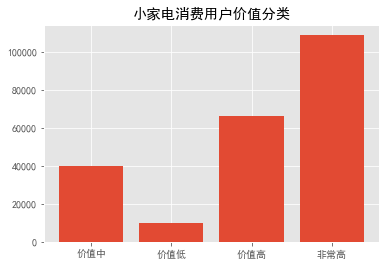

In [96]:
plt.bar(valuegrp_df["cvl_glob_valuegrp"],valuegrp_df["user_count"])
plt.title("小家电消费用户价值分类")

## 用户价值标准得分

In [97]:
user_values = vaild_order_user_df.groupby("cvl_glob_values",as_index = False)["user_log_acct"].agg({"user_count":"count"})
user_values

,cvl_glob_values,user_count
0,-1.000000,7317
1,0.117239,1
2,0.117247,1
3,0.124686,2
4,0.124761,1
...,...,...
175205,79.268166,12
175206,79.422386,1
175207,79.553925,1
175208,79.698060,1


In [98]:
# remove -1
#user_values["cvl_glob_values"] = user_values["cvl_glob_values"].astype(float)
user_values = user_values[user_values.cvl_glob_values >=0]
user_values

,cvl_glob_values,user_count
1,0.117239,1
2,0.117247,1
3,0.124686,2
4,0.124761,1
5,0.126324,1
...,...,...
175205,79.268166,12
175206,79.422386,1
175207,79.553925,1
175208,79.698060,1


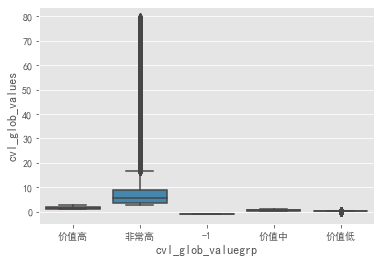

In [99]:
sns.boxplot(x = "cvl_glob_valuegrp", y = "cvl_glob_values",data = vaild_order_user_df)

In [100]:
vaild_order_user_df.groupby(["cvl_glob_valuegrp"], as_index = False)["cvl_glob_values"].max()

,cvl_glob_valuegrp,cvl_glob_values
0,-1,-1.000000
1,价值中,1.000728
2,价值低,0.349877
3,价值高,2.671667
4,非常高,79.807945


In [101]:
vaild_order_user_df.groupby(["cvl_glob_valuegrp"], as_index = False)["cvl_glob_values"].min()

,cvl_glob_valuegrp,cvl_glob_values
0,-1,-1.000000
1,价值中,0.349909
2,价值低,0.117239
3,价值高,1.000807
4,非常高,2.671753


## 用户忠诚度

In [102]:
vaild_order_user_df.cvl_glob_loyalty.nunique()

8

In [103]:
vaild_order_user_df.cvl_glob_loyalty.unique()

array(['高度-忠诚型', '-1', '远期-偶然型', '中度-忠诚型', '近期-普通型', '远期-普通型', '远期-投机型',
       '近期-投机型'], dtype=object)

In [104]:
loyalty_df = vaild_order_user_df.groupby("cvl_glob_loyalty", as_index=False)["user_log_acct"].agg(
    {"type_count": "count"}).sort_values(by="type_count", ascending=False)
loyalty_df

,cvl_glob_loyalty,type_count
7,高度-忠诚型,161200
1,中度-忠诚型,21636
3,近期-普通型,19416
6,远期-普通型,12217
4,远期-偶然型,7777
0,-1,6706
2,近期-投机型,2807
5,远期-投机型,840


In [105]:
loyalty_df = loyalty_df[loyalty_df.cvl_glob_loyalty!="-1"]
loyalty_df["per%"] = loyalty_df["type_count"]/loyalty_df["type_count"].sum()
loyalty_df

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cvl_glob_loyalty,type_count,per%
7,高度-忠诚型,161200,0.713612
1,中度-忠诚型,21636,0.095780
3,近期-普通型,19416,0.085952
6,远期-普通型,12217,0.054083
4,远期-偶然型,7777,0.034428
2,近期-投机型,2807,0.012426
5,远期-投机型,840,0.003719


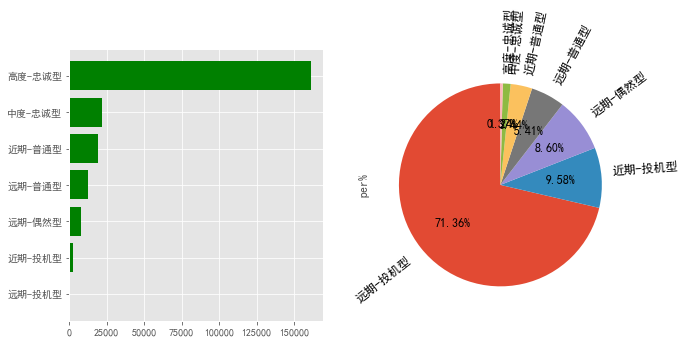

In [106]:
x = loyalty_df["cvl_glob_loyalty"][::-1]
y1 = loyalty_df["type_count"][::-1]

# visualization

plt.figure(figsize = (10,5))

plt.subplot(121)
plt.barh(y = x, width = y1,color = "g")


plt.subplot(122)
loyalty_df["per%"].plot.pie(labels = x, autopct = "%1.2f%%",startangle = 90, textprops = {"fontsize":12},rotatelabels = True)
#plt.pie(y1, labels = x, autopct = "%1.2f%%",startangle = 90, textprops = {"fontsize":12},rotatelabels = True)


## 平台影响力

In [107]:
platform_df = vaild_order_user_df.groupby("cvl_glob_platform",as_index = False)["user_log_acct"].agg({"platform":"count"})
platform_df = platform_df[platform_df.cvl_glob_platform>=0]
platform_df

,cvl_glob_platform,platform
1,4.784754,1
2,6.471939,1
3,6.825068,1
4,6.966445,1
5,7.047620,2
...,...,...
88337,99.892613,1
88338,99.919297,1
88339,99.923220,1
88340,99.931090,1


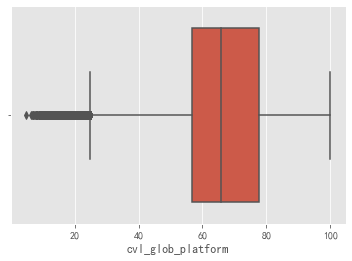

In [108]:
sns.boxplot(platform_df.cvl_glob_platform)

## 用户价值小结

典型的小家电消费者**（现在或）曾经是plus会员**，有**非常高的用户价值**（但价值标准得分存在很大差异）；

他是**高度-忠诚型**用户，有比较高的平台影响力。

*************

**结论**

促销时可以针对会员进行推送，对用户价值高的消费者，挖掘他们的兴趣爱好以及对应的商品分类，推送合适的活动、给予合适的价格；

因为他们的平台影响力高，更应该推送高质量商品，从正面引导其他用户消费。

# 用户敏感度

## 促销敏感度

In [109]:
def valid_user_groupby(col_name, groupby_name, agg_way):
    return vaild_order_user_df.groupby(col_name, as_index = False)["user_log_acct"].agg({groupby_name : agg_way})

这个cfv_sens_promotion标签是个复合标签，其中：

复购-敏感度：

* L1-近一年有复购用户；
* L2-近一年无复购用户；
* L3-一年前有复购用户；
* L4-一年前无复购用户；

1-不敏感
2-轻度敏感
3-中度敏感
4-高度敏感
5-极度敏感

**人数最多的标签是L1-4，即“近一年有复购用户-高度敏感”**

In [110]:
sense_df = valid_user_groupby("cfv_sens_promotion","sens_count","count")
sense_df

,cfv_sens_promotion,sens_count
0,-1,1197
1,L1-1,8658
2,L1-2,39311
3,L1-3,24920
4,L1-4,134189
5,L1-5,10509
6,L2-1,3116
7,L2-2,2529
8,L2-3,289
9,L2-4,179


### 整体敏感度

In [111]:
# 拆分复合标签

sense_df = sense_df[sense_df.cfv_sens_promotion != "-1"] #去掉-1
sense_df["repurchase"] = sense_df["cfv_sens_promotion"].str.extract(r'(L[0-9])-') #复购行为
sense_df["p_sense"] = sense_df["cfv_sens_promotion"].str.extract(r'L[0-9]-([0-9])') #敏感度
sense_df.head()

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,cfv_sens_promotion,sens_count,repurchase,p_sense
1,L1-1,8658,L1,1
2,L1-2,39311,L1,2
3,L1-3,24920,L1,3
4,L1-4,134189,L1,4
5,L1-5,10509,L1,5


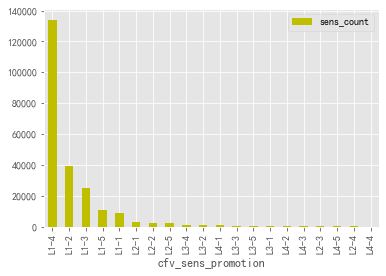

In [112]:
sense_df.sort_values(by = "sens_count", ascending = False).plot(kind = "bar", x = "cfv_sens_promotion", y = "sens_count"
                                                                , color = "y")

In [113]:
# 整体敏感度
p_sense = sense_df.groupby("p_sense", as_index = False)["sens_count"].sum()
p_sense

,p_sense,sens_count
0,1,13013
1,2,43025
2,3,26214
3,4,135699
4,5,13451


In [114]:
repurchase = sense_df.groupby("repurchase", as_index = False)["sens_count"].sum()
repurchase

,repurchase,sens_count
0,L1,217587
1,L2,8335
2,L3,3779
3,L4,1701


In [115]:
p_sense_label = ["不敏感", "轻度敏感", "中度敏感", "高度敏感", "极度敏感"]
repurchase_label = ["近一年有复购用户","近一年无复购用户","一年前有复购用户","一年前无复购用户"]

Text(0.5, 1.0, '小家电消费用户近一年复购情况')

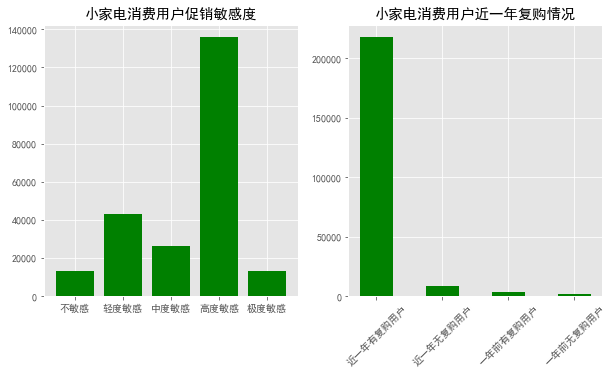

In [116]:
plt.figure(figsize = (10,5))

plt.subplot(121) # p_sense
plt.bar(p_sense_label,p_sense["sens_count"], color = "g")
plt.title("小家电消费用户促销敏感度")

plt.subplot(122)
plt.bar(repurchase_label, repurchase["sens_count"],width = 0.5, color = 'g')
plt.xticks(rotation = 45)
plt.title("小家电消费用户近一年复购情况")

In [117]:
sense_df2 = sense_df.groupby(["p_sense","repurchase"], as_index = False)["sens_count"].sum()
sense_df2.head()

,p_sense,repurchase,sens_count
0,1,L1,8658
1,1,L2,3116
2,1,L3,469
3,1,L4,770
4,2,L1,39311


### 敏感度+复购

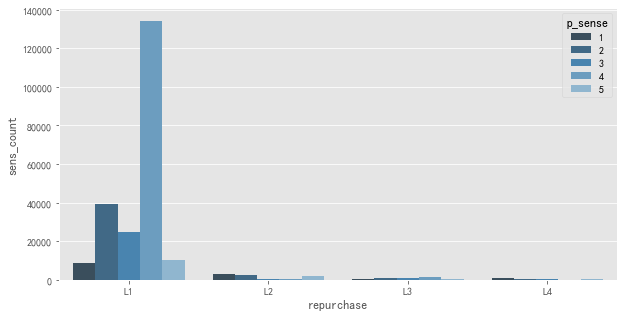

In [118]:
plt.figure(figsize = (10,5))
sns.barplot(x="repurchase", y="sens_count", hue="p_sense", data=sense_df2,palette="Blues_d")

从整体和部分看，都可以得到以下结论：

1. 多数顾客近一年都有复购
2. 多数顾客对促销非常敏感（4）
3. 多数顾客属于“L1-4”，近一年复购且高度敏感

对于L1-4这部分用户，需要保持（并提高）复购率，且通过优惠券、打折、礼品等方式吸引他们；

对于其他类型用户，可以尝试不同的活动方式吸引

## 评论敏感度

cfv_sens_comment是复合用户标签，含义参考促销敏感度

In [119]:
sens_comment_df = valid_user_groupby("cfv_sens_comment","sens_count","count")
sens_comment_df = sens_comment_df[sens_comment_df.cfv_sens_comment != "-1"]
sens_comment_df

,cfv_sens_comment,sens_count
1,L1-1,3866
2,L1-2,11078
3,L1-3,38064
4,L1-4,42039
5,L1-5,123151
6,L2-1,1410
7,L2-2,1233
8,L2-3,1683
9,L2-4,2075
10,L2-5,1697


### 敏感度+复购

In [120]:
# 拆分复合标签

sens_comment_df["repurchase"] = sens_comment_df["cfv_sens_comment"].str.extract(r'(L[0-9])-') #复购行为
sens_comment_df["c_sense"] = sens_comment_df["cfv_sens_comment"].str.extract(r'L[0-9]-([0-9])') #敏感度
sens_comment_df.head()

,cfv_sens_comment,sens_count,repurchase,c_sense
1,L1-1,3866,L1,1
2,L1-2,11078,L1,2
3,L1-3,38064,L1,3
4,L1-4,42039,L1,4
5,L1-5,123151,L1,5


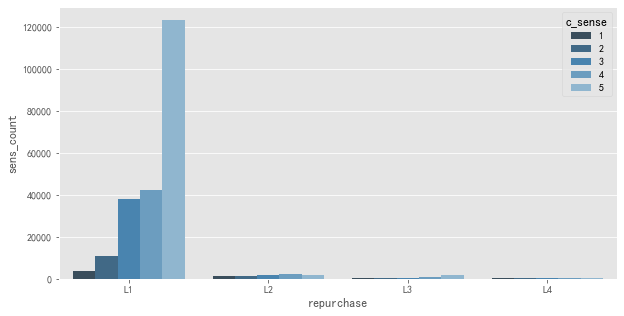

In [121]:
plt.figure(figsize = (10,5))
sns.barplot(x="repurchase", y="sens_count", hue="c_sense", data=sens_comment_df,palette="Blues_d")

### 整体情况

In [124]:
repurchase2 = sens_comment_df.groupby("c_sense",as_index = False)["sens_count"].agg({"repurchase_count":"sum"})
repurchase2

,c_sense,repurchase_count
0,1,5893
1,2,13168
2,3,40463
3,4,45554
4,5,126994


(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000.]),
 <a list of 8 Text yticklabel objects>)

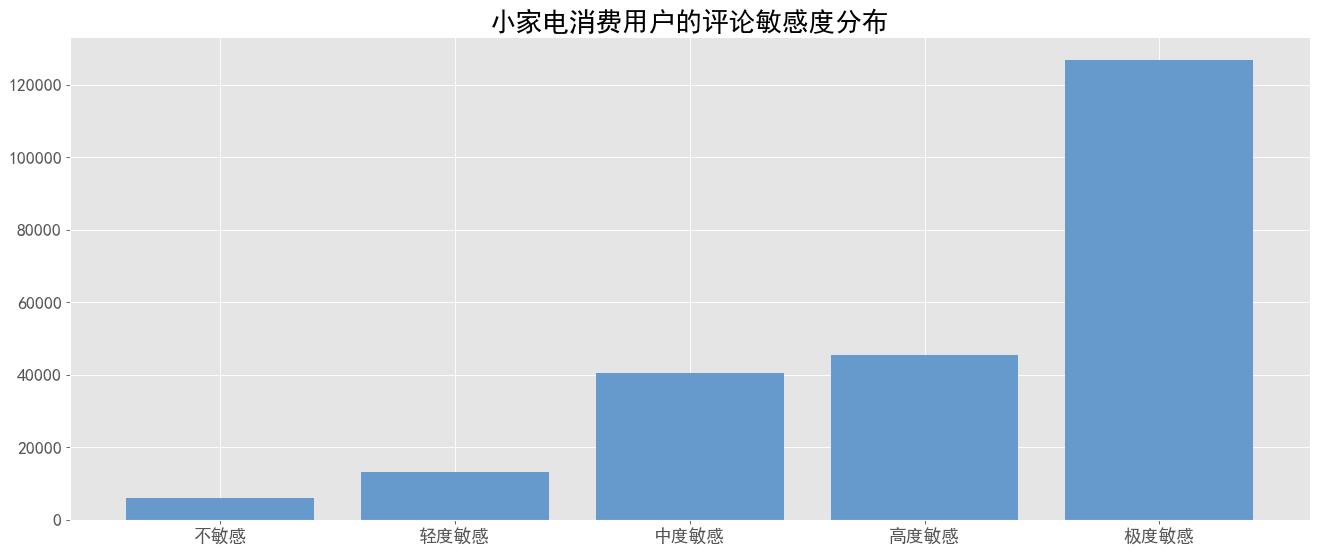

In [136]:
c_sense_label = ["不敏感", "轻度敏感", "中度敏感", "高度敏感", "极度敏感"]

plt.figure(figsize=(20,8),dpi=80)
plt.bar(c_sense_label, repurchase2["repurchase_count"],color = '#6699CC')
plt.title("小家电消费用户的评论敏感度分布", size=24)

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

小结：

有复购的用户更多、并且这些人通常对评论更加敏感

## 用户敏感小结

小家电用户通常是近一年有复购行为、对于优惠高敏感、对评论极度敏感的用户。

**结论**

促销活动的优惠力度要能够大到足够吸引他们，并且筛选优质、差评低的商品。

文案可以提到优惠大，好评，物美价廉等特点。